# **Modelado**

En este apartado se implementan los modelos de clasificación descritos en el proyecto sobre el conjunto de currículums previamente procesado. Cada modelo se entrena, evalúa y compara utilizando métricas estándar para clasificación multiclase.

### Métricas de Evaluación

- **Exactitud (Accuracy):** proporción de predicciones correctas sobre el total de ejemplos.  
- **Precisión (Precision):** proporción de verdaderos positivos sobre el total de predicciones positivas.  
- **Exhaustividad (Recall):** proporción de verdaderos positivos detectados sobre el total de positivos reales.  
- **F1-Score:** media armónica entre precisión y recall, útil para evaluar el balance entre ambos.  
- **Matriz de Confusión:** visualiza aciertos y errores por clase, identificando patrones de confusión.  
- **ROC-AUC (cuando aplica):** evalúa la capacidad discriminativa del modelo en escenarios multiclase.


A lo largo del notebook se documenta el flujo completo de cada modelo, incluyendo:
1. Entrenamiento y ajuste de hiperparámetros.  
2. Evaluación mediante las métricas descritas.  

Para todos los modelos evaluados, el **F1-Score Weighted** se establece como la **métrica de rendimiento principal** y **criterio de optimización**. Pues si bien el desbalance de clases fue corregido mediante **data augmentation**, el F1-Score Weighted sigue siendo la métrica más adecuada para evaluar el rendimiento global. Esto se debe a que pondera la contribución de cada clase según su frecuencia efectiva, ofreciendo una evaluación más estable ante posibles variaciones en la distribución de datos entre los conjuntos de entrenamiento, validación y prueba.  A diferencia de la **Accuracy** (susceptible al sesgo hacia clases más frecuentes) y del F1-Score Macro (que otorga el mismo peso a todas las clases, independientemente de su soporte), el F1-Score Weighted proporciona una medida más equilibrada y representativa del desempeño del modelo en el dataset completo.

El análisis inicia con **modelos basados en Transformers** y continúa con **arquitecturas clásicas y ligeras**, permitiendo comparar desempeño y eficiencia entre enfoques.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize


In [ ]:
#| hide-cell

category_map = {
    0: 'ACCOUNTANT',
    1: 'ADVOCATE',
    2: 'AGRICULTURE',
    3: 'APPAREL',
    4: 'ARTS',
    5: 'AUTOMOBILE',
    6: 'AVIATION',
    7: 'BANKING',
    8: 'BPO',
    9: 'BUSINESS-DEVELOPMENT',
    10: 'CHEF',
    11: 'CONSTRUCTION',
    12: 'CONSULTANT',
    13: 'DESIGNER',
    14: 'DIGITAL-MEDIA',
    15: 'ENGINEERING',
    16: 'FINANCE',
    17: 'FITNESS',
    18: 'HEALTHCARE',
    19: 'HR',
    20: 'INFORMATION-TECHNOLOGY',
    21: 'PUBLIC-RELATIONS',
    22: 'SALES',
    23: 'TEACHER'
}

In [4]:
def mostrar_matriz_confusion(y_true, y_pred, category_map, titulo):
    """Genera una matriz de confusión con paleta morada personalizada."""
    cm = confusion_matrix(y_true, y_pred)
    label_names = [category_map[i] for i in sorted(list(set(y_true)))]

    # Paleta morada integrada
    palette = sns.blend_palette(["#D5C7EF", "#9c69c2"], n_colors=20)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt='d',
        cmap=palette,
        cbar_kws={'label': 'Cantidad'},
        linewidths=0.5, linecolor='gray',
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel('Predicho', fontsize=13, fontweight='bold')
    plt.ylabel('Verdadero', fontsize=13, fontweight='bold')
    plt.title(titulo, fontsize=15, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

In [5]:
def mostrar_curvas_roc(y_true, y_prob, num_classes, titulo):
    """Dibuja curvas ROC por clase."""
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(titulo)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def analizar_errores(y_true, y_pred, category_map, nombre_modelo):
    """Imprime análisis de errores global y por clase."""
    errores = np.sum(y_true != y_pred)
    total = len(y_true)

    print("=" * 60)
    print(f" RESUMEN DE ERRORES - {nombre_modelo}")
    print("=" * 60)
    print(f" Predicciones correctas: {total - errores}")
    print(f" Predicciones incorrectas: {errores}")
    print(f" Total de ejemplos: {total}")
    print(f" Accuracy: {(1 - errores / total) * 100:.2f}%")
    print(f" Tasa de error: {(errores / total) * 100:.2f}%")
    print("=" * 60)

    print("\n ERRORES POR CLASE:")
    print("-" * 60)
    for clase in np.unique(y_true):
        mask = y_true == clase
        total_clase = np.sum(mask)
        errores_clase = np.sum((y_true == clase) & (y_pred != clase))
        accuracy_clase = (total_clase - errores_clase) / total_clase
        print(f"{category_map[clase]:25s}: {errores_clase}/{total_clase} errores "
              f"({accuracy_clase*100:.2f}% accuracy)")

    print("\n CONFUSIONES MÁS COMUNES:")
    print("-" * 60)
    confusiones = {}
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            key = (y_true[i], y_pred[i])
            confusiones[key] = confusiones.get(key, 0) + 1

    top_conf = sorted(confusiones.items(), key=lambda x: x[1], reverse=True)[:10]
    for (true, pred), count in top_conf:
        print(f"{category_map[true]} → {category_map[pred]}: {count} veces ({count/errores*100:.1f}% de errores)")

In [7]:
def graficar_historial_entrenamiento(history, results_dir, nombre_modelo):
    """Genera gráficas de pérdida y métricas de entrenamiento/validación."""
    color_train = "#9c69c2"
    color_val = "#D5C7EF"

    print(f"\n Generando gráficas de entrenamiento para {nombre_modelo}...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('white')

    # Pérdida
    ax1 = axes[0]
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2.5, marker='o', markersize=6, color=color_train, alpha=0.85)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, marker='s', markersize=6, color=color_val, alpha=0.85)
    ax1.set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
    ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, frameon=True, shadow=True)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_facecolor('#fafafa')

    # Métrica F1 Weighted
    ax2 = axes[1]
    ax2.plot(history.history['f1_weighted'], label='Train F1 (Weighted)', linewidth=2.5, marker='o', markersize=6, color=color_train, alpha=0.85)
    ax2.plot(history.history['val_f1_weighted'], label='Validation F1 (Weighted)', linewidth=2.5, marker='s', markersize=6, color=color_val, alpha=0.85)
    ax2.set_title('Model F1-Score (Weighted)', fontsize=16, fontweight='bold', pad=15)
    ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax2.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, frameon=True, shadow=True)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_facecolor('#fafafa')

    plt.tight_layout()
    path_save = os.path.join(results_dir, f"{nombre_modelo.lower()}_training_history.png")
    plt.savefig(path_save, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f" Gráficas guardadas en: {path_save}")


In [8]:
def graficar_historial_xgboost(df_history, results_dir, nombre_modelo):


    color_train = "#9c69c2"
    color_val = "#D5C7EF"

    print(f"\n Generando gráficas de entrenamiento para {nombre_modelo}...")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.patch.set_facecolor('white')

    # --- Pérdida ---
    ax1 = axes[0]
    ax1.plot(df_history['Epoch'], df_history['Train Loss'], label='Train Loss',
             linewidth=2.5, marker='o', markersize=6, color=color_train, alpha=0.9)
    ax1.plot(df_history['Epoch'], df_history['Val Loss'], label='Validation Loss',
             linewidth=2.5, marker='s', markersize=6, color=color_val, alpha=0.9)
    ax1.set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
    ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, frameon=True, shadow=True)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_facecolor('#fafafa')

    # --- F1 Weighted ---
    ax2 = axes[1]
    ax2.plot(df_history['Epoch'], df_history['Train F1 Weighted'], label='Train F1 (Weighted)',
             linewidth=2.5, marker='o', markersize=6, color=color_train, alpha=0.9)
    ax2.plot(df_history['Epoch'], df_history['Val F1 Weighted'], label='Validation F1 (Weighted)',
             linewidth=2.5, marker='s', markersize=6, color=color_val, alpha=0.9)
    ax2.set_title('Model F1-Score (Weighted)', fontsize=16, fontweight='bold', pad=15)
    ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax2.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, frameon=True, shadow=True)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_facecolor('#fafafa')

    plt.tight_layout()
    path_save = os.path.join(results_dir, f"{nombre_modelo.lower()}_training_history.png")
    plt.savefig(path_save, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print(f" Gráficas guardadas en: {path_save}")


La métrica personalizada **`F1WeightedScore`** fue implementada en TensorFlow/Keras con el objetivo de calcular el **F1-Score ponderado** durante el entrenamiento y evaluación de modelos de clasificación multiclase. Esta clase extiende `tf.keras.metrics.Metric` y mantiene una **matriz de confusión acumulada** como variable de estado, actualizada en cada batch con las predicciones y etiquetas verdaderas. A partir de dicha matriz se derivan los valores de **verdaderos positivos (TP), falsos positivos (FP) y falsos negativos (FN)** por clase, con los que se calculan precisión y recall, y posteriormente el F1 por clase. El resultado final se pondera según el **soporte (número de ejemplos por clase)**, produciendo un F1 global que refleja el rendimiento del modelo considerando el desbalance de clases. Esta métrica se diseñó para complementar las métricas estándar de Keras y proporcionar un criterio más representativo en escenarios multiclase con distribución desigual.  

$$
F1_{weighted} = \frac{\sum_{i=1}^{C} \; \frac{2 \cdot TP_i}{2 \cdot TP_i + FP_i + FN_i} \cdot n_i}{\sum_{i=1}^{C} n_i}
$$

donde:  

- \(C\) = número total de clases  
- \(TP_i\) = verdaderos positivos de la clase \(i\)  
- \(FP_i\) = falsos positivos de la clase \(i\)  
- \(FN_i\) = falsos negativos de la clase \(i\)  
- \(n_i\) = soporte de la clase \(i\) (número de ejemplos reales en esa clase)  




In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

class F1WeightedScore(tf.keras.metrics.Metric):
    def __init__(self, name="f1_weighted", num_classes=None, **kwargs):
        super(F1WeightedScore, self).__init__(name=name, **kwargs)
        if num_classes is None:
            raise ValueError("Debes proporcionar 'num_classes'.")
        self.num_classes = num_classes
        self.cm = self.add_weight(
            name='cm', 
            shape=(self.num_classes, self.num_classes), 
            initializer='zeros', 
            dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)
        
        batch_cm = tf.math.confusion_matrix(
            labels=y_true_classes,
            predictions=y_pred_classes,
            num_classes=self.num_classes
        )
        self.cm.assign_add(tf.cast(batch_cm, tf.float32))

    def result(self):
        TP = tf.linalg.diag_part(self.cm)
        FP = tf.reduce_sum(self.cm, axis=0) - TP  
        FN = tf.reduce_sum(self.cm, axis=1) - TP  
        
        precision = TP / (TP + FP + K.epsilon())
        recall = TP / (TP + FN + K.epsilon())
        f1_score_per_class = (2. * precision * recall) / (precision + recall + K.epsilon())
        
        support = tf.reduce_sum(self.cm, axis=1)
        total_support = tf.reduce_sum(support)
        
        weighted_f1 = tf.reduce_sum(f1_score_per_class * support) / (total_support + K.epsilon())
        
        return weighted_f1

    def reset_state(self):
        self.cm.assign(tf.zeros_like(self.cm))



## Modelo 1: DistilBERT

In [8]:
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback
)
from datasets import Dataset
import torch
from scipy.special import softmax
from sklearn.utils.class_weight import compute_class_weight


/home/davzz/miniconda3/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Para este modelo se utilizó DistilBERT-base-uncased, descargado previamente desde Hugging Face y almacenado localmente en MODEL_PATH. Esto permite cargar el modelo sin conexión y acelerar el proceso de entrenamiento. 

In [37]:
MODEL_NAME = "distilbert-base-uncased"
MODEL_PATH = "modelos/distilbert-base-uncased"
OUTPUT_DIR = "./results_distilbert"
NUM_CLASSES = 24  

Los datasets de entrenamiento, validación y prueba se cargan desde archivos `.npz` que contienen `input_ids`, `attention_mask` y `labels`. Estos tensores se convierten en objetos `Dataset` de Hugging Face, facilitando su integración con el `Trainer` para entrenamiento y evaluación.

In [10]:
# 1. Carga de Datos Tokenizados
def load_data(file_path):
    data = np.load(file_path)
    return {
        'input_ids': data['input_ids'],
        'attention_mask': data['attention_mask'],
        'labels': data['labels']
    }

train_data = load_data('processed_data/distilbert_train.npz')
val_data = load_data('processed_data/distilbert_val.npz')
test_data = load_data('processed_data/distilbert_test.npz')

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset_hf = Dataset.from_dict(test_data)

Se instancia `AutoModelForSequenceClassification` desde la ruta local, indicando el número de clases. El modelo se ubica automáticamente en el dispositivo disponible (`device_map="auto"`). Se carga también el tokenizer correspondiente para asegurar la compatibilidad de los textos con el modelo.

In [11]:
# 2. Cargar modelo local
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_CLASSES,
    use_safetensors=False,
    device_map="auto",
    torch_dtype=torch.float32 
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

print(" Modelo local cargado correctamente.")
print(f" Dispositivo: {next(model.parameters()).device}")



`torch_dtype` is deprecated! Use `dtype` instead!


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at modelos/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Modelo local cargado correctamente.
 Dispositivo: cuda:0


In [12]:
# 3. Función de Métricas
def compute_metrics(p):
    if p.predictions is None or np.isnan(p.predictions).any():
        print(" Predicciones inválidas o vacías.")
        return {
            'accuracy': 0.0,
            'f1_weighted': 0.0,
            'f1_macro': 0.0,
            'precision_weighted': 0.0,
            'recall_weighted': 0.0,
            'roc_auc_macro': 0.0
        }

    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    probs = softmax(p.predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_weighted': f1_score(labels, preds, average='weighted', zero_division=0),
        'f1_macro': f1_score(labels, preds, average='macro', zero_division=0),
        'precision_weighted': precision_score(labels, preds, average='weighted', zero_division=0),
        'recall_weighted': recall_score(labels, preds, average='weighted', zero_division=0),
        'roc_auc_macro': roc_auc_score(labels, probs, multi_class='ovr', average='macro')
    }


In [13]:
# 4. Callback para capturar métricas de TRAIN

class TrainMetricsCallback(TrainerCallback):
    """Callback para calcular métricas en el conjunto de entrenamiento al final de cada epoch"""
    
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset
        self.train_metrics_history = []
    
    def on_epoch_end(self, args, state, control, **kwargs):
        # Evaluar en el conjunto de entrenamiento
        train_output = self.trainer.predict(self.train_dataset)
        train_metrics = compute_metrics(train_output)
        
        # Agregar el epoch actual
        train_metrics['epoch'] = state.epoch
        train_metrics['loss'] = state.log_history[-1].get('loss', None)
        
        self.train_metrics_history.append(train_metrics)
        

Se utilizó un **`WeightedTrainer`** personalizado, que extiende la clase estándar `Trainer` de **Hugging Face**.  
Este *wrapper* ajusta la función de pérdida interna de **Cross-Entropy** (`CrossEntropyLoss`) mediante la inclusión de un vector de pesos **W**:

Formalmente, la función de pérdida optimizada en cada paso de entrenamiento es:

$$
\mathcal{L}(x, y) = \text{CrossEntropyLoss}(x, y, \text{weight}=W)
$$

Esto garantiza que los errores de predicción en las clases con menor frecuencia efectiva reciban una penalización significativamente mayor,  
obligando al modelo a aprender patrones robustos en categorías subrepresentadas.


In [14]:
# 5. Pesos de Clase Balanceados
print("\n Calculando pesos de clase...")
class_weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=train_data['labels'])
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


 Calculando pesos de clase...


El entrenamiento se configuró para optimizar la generalización y manejar el desbalance de clases, con **8 épocas**, **batch size de 16/32** (entrenamiento/evaluación), y una **tasa de aprendizaje de 3e-5** con **500 pasos de calentamiento**. Se aplica **weight decay de 0.01**, evaluaciones y checkpoints al final de cada época, activando **`load_best_model_at_end`** para conservar el modelo con mejor **F1 ponderado**. 


In [15]:
# 6. Argumentos de Entrenamiento
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=20,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_distilbert',
    logging_steps=50,
    eval_strategy="epoch",   
    save_strategy="epoch",         
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    fp16=False,                    
    report_to="none"
)    

Se inicializa el `WeightedTrainer` con el modelo, los datasets, el tokenizer, la función de métricas y un callback de `EarlyStopping` que detiene el entrenamiento si no hay mejora en dos épocas consecutivas. El entrenamiento se lanza con `trainer.train()`, iniciando el fine-tuning de DistilBERT sobre el corpus específico.

In [16]:
# 7. Inicializar Trainer con Callback
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Agregar callback para métricas de train
train_metrics_callback = TrainMetricsCallback(trainer, train_dataset)
trainer.add_callback(train_metrics_callback)

print("\n" + "="*70)
print("🚀 INICIANDO FINE-TUNING DE DISTILBERT")
print("="*70 + "\n")

trainer.train()

print("\n✓ Entrenamiento completado!")



/tmp/ipykernel_48107/317751910.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.



🚀 INICIANDO FINE-TUNING DE DISTILBERT



Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Precision Weighted,Recall Weighted,Roc Auc Macro
1,3.174600,3.156494,0.077307,0.035539,0.033695,0.037370,0.077307,0.736668
2,3.034500,2.621757,0.518703,0.460926,0.460242,0.546053,0.518703,0.915934
3,1.868400,1.509014,0.790524,0.762421,0.753044,0.810530,0.790524,0.968110
4,1.040400,0.799623,0.855362,0.851806,0.845947,0.856420,0.855362,0.981524
5,0.641700,0.628869,0.862843,0.858072,0.852563,0.864235,0.862843,0.984948
6,0.423300,0.575531,0.872818,0.868424,0.864090,0.876264,0.872818,0.982535
7,0.299500,0.584471,0.880299,0.876548,0.871866,0.891924,0.880299,0.981208
8,0.206800,0.576350,0.885287,0.881846,0.877137,0.892063,0.885287,0.984544
9,0.147000,0.673555,0.870324,0.866095,0.861634,0.872288,0.870324,0.982403
10,0.117000,0.602490,0.885287,0.881073,0.876284,0.885406,0.885287,0.982708



✓ Entrenamiento completado!


Una vez entrenado, el modelo se evalúa sobre el conjunto de prueba. Se obtienen las predicciones (`preds`), las etiquetas verdaderas (`labels`) y los textos originales (`test_texts`). Se calculan nuevamente las métricas de rendimiento con compute_metrics, y se imprime un resumen detallado de los resultados finales.


📊 GENERANDO VISUALIZACIONES DEL ENTRENAMIENTO

📋 Resumen del historial:
  - loss: 16 registros
  - val_loss: 16 registros
  - f1_weighted: 16 registros
  - val_f1_weighted: 16 registros

📊 Generando gráficas de entrenamiento para DistilBERT...


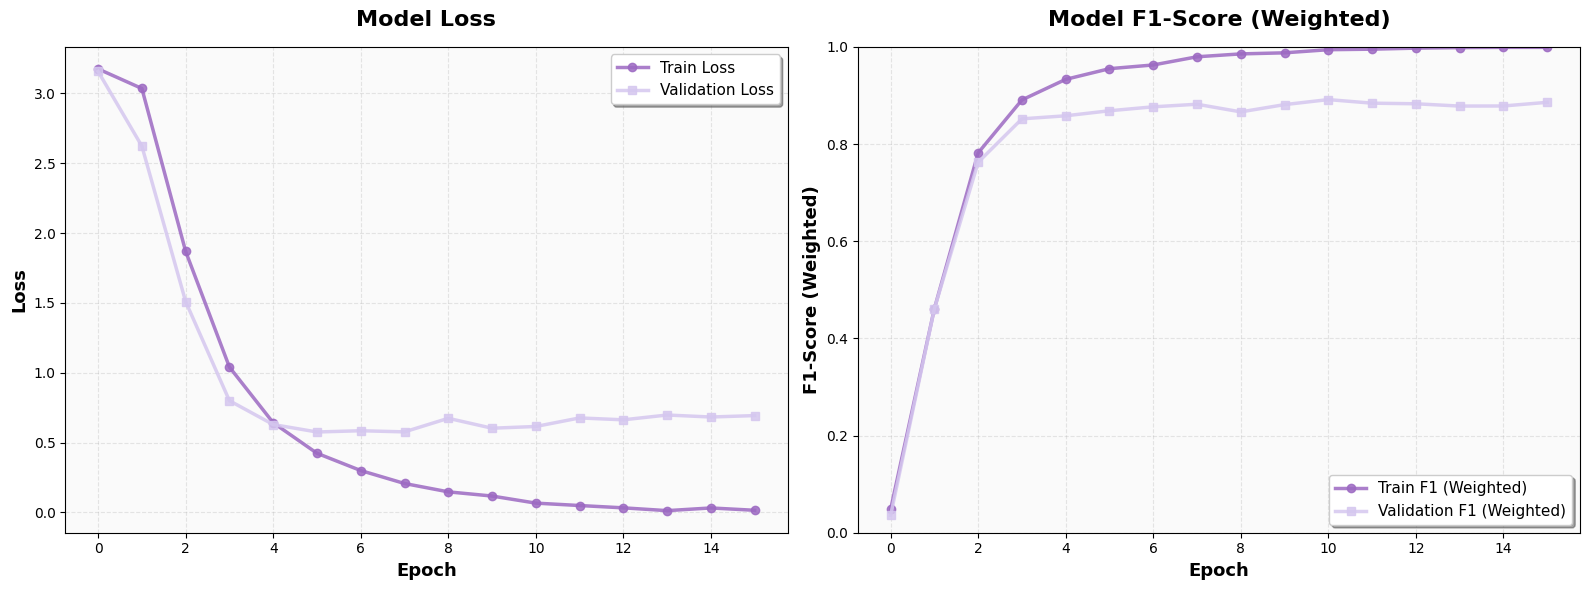

In [ ]:
print("\n" + "="*70)
print(" GENERANDO VISUALIZACIONES DEL ENTRENAMIENTO")
print("="*70)

# Extraer historial del trainer (validación)
log_history = trainer.state.log_history

# Inicializar diccionario de historial
history_dict = {
    'loss': [],
    'val_loss': [],
    'f1_weighted': [],
    'val_f1_weighted': []
}

# Extraer métricas de TRAIN del callback
train_metrics = train_metrics_callback.train_metrics_history
for tm in train_metrics:
    if tm['loss'] is not None:
        history_dict['loss'].append(tm['loss'])
    history_dict['f1_weighted'].append(tm['f1_weighted'])

# Extraer métricas de VALIDACIÓN del log_history
for entry in log_history:
    if 'eval_loss' in entry:
        history_dict['val_loss'].append(entry['eval_loss'])
        
        if 'eval_f1_weighted' in entry:
            history_dict['val_f1_weighted'].append(entry['eval_f1_weighted'])

# Asegurar que todas las listas tengan la misma longitud
min_length = min(len(v) for v in history_dict.values() if len(v) > 0)
for key in history_dict:
    if len(history_dict[key]) > min_length:
        history_dict[key] = history_dict[key][:min_length]

print("\n📋 Resumen del historial:")
for key, values in history_dict.items():
    if len(values) > 0:
        print(f"  - {key}: {len(values)} registros")

# ============================================================================
# 9. GRAFICAR HISTORIAL DE ENTRENAMIENTO
# ============================================================================

color_train = "#9c69c2"  
color_val = "#D5C7EF"    

print(f"\n Generando gráficas de entrenamiento para DistilBERT...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('white')

# ------------------ Pérdida ------------------
ax1 = axes[0]
if len(history_dict['loss']) > 0:
    ax1.plot(history_dict['loss'], label='Train Loss',
             linewidth=2.5, marker='o', markersize=6,
             color=color_train, alpha=0.85)
if len(history_dict['val_loss']) > 0:
    ax1.plot(history_dict['val_loss'], label='Validation Loss',
             linewidth=2.5, marker='s', markersize=6,
             color=color_val, alpha=0.85)

ax1.set_title('Model Loss', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, frameon=True, shadow=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#fafafa')

# ------------------ F1 Weighted ------------------
# ------------------ F1 Weighted ------------------
ax2 = axes[1]

if len(history_dict['f1_weighted']) > 0:
    ax2.plot(history_dict['f1_weighted'], label='Train F1 (Weighted)',
             linewidth=2.5, marker='o', markersize=6,
             color=color_train, alpha=0.85)
if len(history_dict['val_f1_weighted']) > 0:
    ax2.plot(history_dict['val_f1_weighted'], label='Validation F1 (Weighted)',
             linewidth=2.5, marker='s', markersize=6,
             color=color_val, alpha=0.85)

ax2.set_title('Model F1-Score (Weighted)', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('F1-Score (Weighted)', fontsize=13, fontweight='bold')
# >> ESTA ES LA LÍNEA AÑADIDA PARA FIJAR EL LÍMITE DEL EJE Y
ax2.set_ylim(0.0, 1.0) 
# <<
ax2.legend(fontsize=11, frameon=True, shadow=True)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#fafafa')

plt.tight_layout()
os.makedirs(OUTPUT_DIR, exist_ok=True)
path_save = os.path.join(OUTPUT_DIR, "distilbert_training_history.png")
plt.savefig(path_save, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

El proceso de **fine-tuning** de **DistilBERT** resultó en una **rápida convergencia**, alcanzando un $F1\text{-}Score_{Weighted}$ máximo de $0.8914$ en la **Época** $11$. La estabilidad de la $Validation\ Loss$ ($\approx 0.6$) y el continuo descenso de la $Training\ Loss$ a valores cercanos a $0$ (Época $16$) confirma la presencia de **sobreajuste**. El $EarlyStoppingCallback$ detuvo el proceso eficientemente en la **Época** $16$, asegurando la selección de la iteración con la mejor **capacidad de generalización**.

In [18]:
# 6. Evaluación en el Test Set

predictions = trainer.predict(test_dataset_hf)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

with open("processed_data/X_test_texts.pkl", "rb") as f:
    X_test = pickle.load(f)

test_texts = X_test  

In [19]:
predictions = trainer.predict(test_dataset_hf)
metrics = compute_metrics(predictions)

print("\n--- Resultados Finales en el Test Set (DistilBERT) ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



--- Resultados Finales en el Test Set (DistilBERT) ---
accuracy: 0.9102
f1_weighted: 0.9094
f1_macro: 0.9073
precision_weighted: 0.9138
recall_weighted: 0.9102
roc_auc_macro: 0.9917


El modelo **DistilBERT**, seleccionado según el mejor $F1$-$Score_{Weighted}$ en el conjunto de validación (Época $11$), fue evaluado sobre el conjunto de **prueba**, el cual conserva la distribución original y desbalanceada de clases.

#### Métricas de rendimiento en el conjunto de prueba

| **Métrica**            | **Valor**  | **Observación Técnica**                                                                 |
|------------------------|-------------|------------------------------------------------------------------------------------------|
| Accuracy (Exactitud)   | 91.02 %     | Alta tasa de aciertos globales.                                                         |
| F1-Score Weighted      | 90.94 %     | Métrica clave: alto rendimiento ponderado por el soporte real de las clases.            |
| F1-Score Macro         | 90.73 %     | Rendimiento equilibrado entre clases, reflejando la eficacia del *data augmentation*.   |
| Precision Weighted     | 91.38 %     | Alta fiabilidad en las predicciones positivas.                                          |
| Recall Weighted        | 91.02 %     | Elevada capacidad para detectar instancias positivas.                                   |
| ROC AUC Macro          | 99.17 %     | Excelente capacidad discriminativa entre las 24 clases.                                 |

El modelo exhibe una **generalización sobresaliente**, alcanzando un $F1$-$Score_{Weighted}$ de **90.94 %** en el conjunto de prueba, superior al máximo obtenido durante la validación (0.8914).  

- **Balance y robustez:** La convergencia entre los valores de $F1_{Weighted}$ (90.94 %) y $F1_{Macro}$ (90.73 %) confirma la efectividad del *fine-tuning* y de la **pérdida ponderada**, logrando un rendimiento casi uniforme entre las 24 clases.  
- **Capacidad discriminativa:** El $ROC\ AUC_{Macro}$ de 99.17 % evidencia una excelente separación entre clases y la solidez de las **representaciones contextuales** aprendidas.  

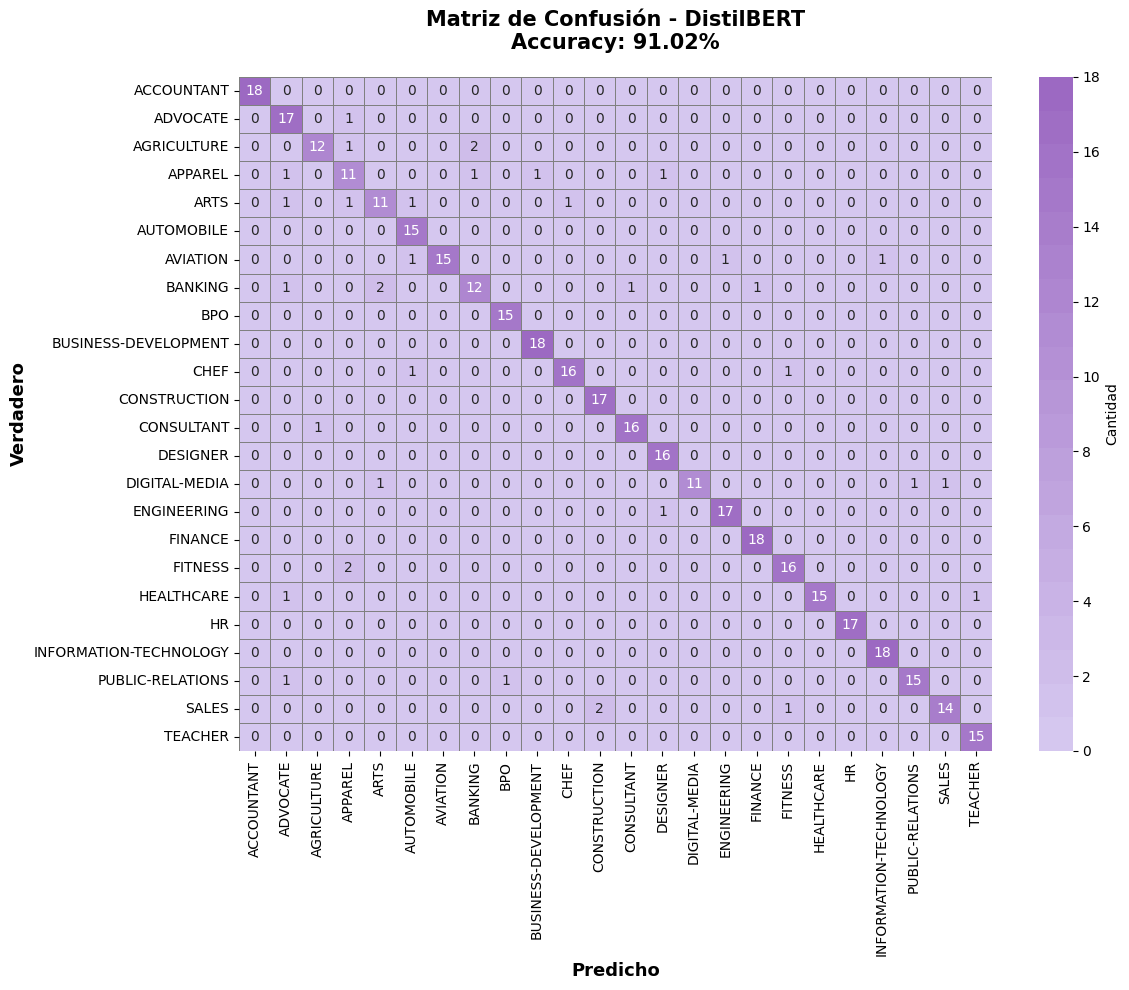

In [20]:
mostrar_matriz_confusion(
    y_true=labels,
    y_pred=preds,
    category_map=category_map,
    titulo=f"Matriz de Confusión - DistilBERT\nAccuracy: {metrics['accuracy']*100:.2f}%"
)

 El análisis de la **Matriz de Confusión** muestra que el modelo clasifica correctamente la gran mayoría de las instancias dentro de las **20 categorías profesionales** definidas, con los errores de clasificación concentrados principalmente en **confusiones lógicas entre clases semánticamente relacionadas**.

La **diagonal principal** de la matriz presenta conteos dominantes de **Verdaderos Positivos**, lo que refleja una alta **Sensibilidad (Recall)** y **Precisión (Precision)** para la mayoría de las clases. Además, se observan **categorías que alcanzan una clasificación perfecta (100 %)**, evidenciando la solidez del modelo para distinguir patrones bien definidos en ciertas profesiones.

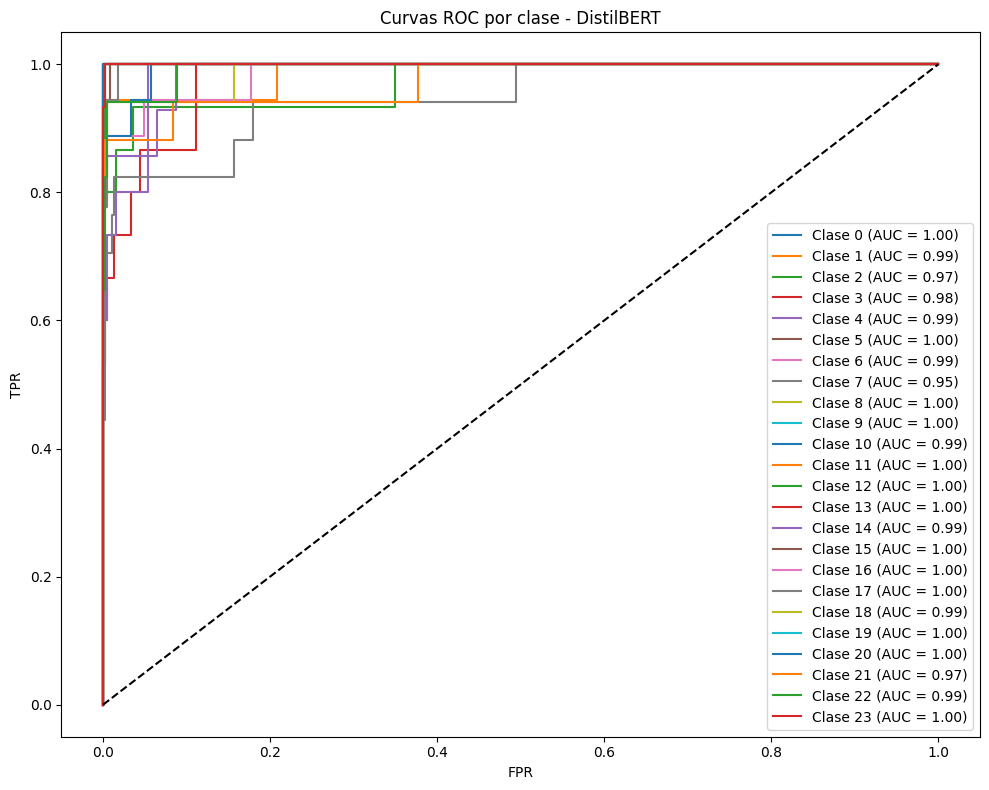

In [21]:
probs = softmax(predictions.predictions, axis=1)

mostrar_curvas_roc(
    y_true=labels,
    y_prob=probs,
    num_classes=NUM_CLASSES,
    titulo="Curvas ROC por clase - DistilBERT"
)

El análisis de las **Curvas ROC** confirma que el modelo **DistilBERT** posee una **capacidad predictiva excepcional** para la tarea de clasificación. Los valores de **AUC** cercanos o iguales a **1.00** indican que el modelo asigna consistentemente una **probabilidad más alta a las instancias de la clase positiva** que a las de la clase negativa, prácticamente en todas las categorías.

En términos prácticos, esto demuestra que el modelo es **altamente confiable al clasificar nuevas instancias**, y que sus **puntuaciones de confianza (probabilidades)** son **estadísticamente significativas y coherentes** con las verdaderas etiquetas, validando la solidez de su comportamiento probabilístico.


### Análisis de errores

En esta sección se realiza un análisis detallado del rendimiento del modelo más allá de las métricas agregadas. Primero, se calcula el número total de errores, la tasa de error y el accuracy global sobre el conjunto de prueba. Luego, se examina el desempeño por clase, identificando cuántos ejemplos fueron mal clasificados en cada categoría y calculando el accuracy específico por clase, lo que permite detectar posibles sesgos o debilidades del modelo en clases minoritarias.

Finalmente, se analizan las confusiones más frecuentes, es decir, los pares de clases en los que el modelo tiende a equivocarse con mayor regularidad. Este análisis es clave para entender patrones de ambigüedad semántica entre categorías y orientar futuras mejoras en el preprocesamiento, la arquitectura o el balance de clases.

In [22]:
analizar_errores(
    y_true=labels,
    y_pred=preds,
    category_map=category_map,
    nombre_modelo="DistilBERT"
)

 RESUMEN DE ERRORES - DistilBERT
 Predicciones correctas: 365
 Predicciones incorrectas: 36
 Total de ejemplos: 401
 Accuracy: 91.02%
 Tasa de error: 8.98%

 ERRORES POR CLASE:
------------------------------------------------------------
ACCOUNTANT               : 0/18 errores (100.00% accuracy)
ADVOCATE                 : 1/18 errores (94.44% accuracy)
AGRICULTURE              : 3/15 errores (80.00% accuracy)
APPAREL                  : 4/15 errores (73.33% accuracy)
ARTS                     : 4/15 errores (73.33% accuracy)
AUTOMOBILE               : 0/15 errores (100.00% accuracy)
AVIATION                 : 3/18 errores (83.33% accuracy)
BANKING                  : 5/17 errores (70.59% accuracy)
BPO                      : 0/15 errores (100.00% accuracy)
BUSINESS-DEVELOPMENT     : 0/18 errores (100.00% accuracy)
CHEF                     : 2/18 errores (88.89% accuracy)
CONSTRUCTION             : 0/17 errores (100.00% accuracy)
CONSULTANT               : 1/17 errores (94.12% accuracy)
DES

Los errores del modelo **DistilBERT** revelan **patrones de confusión entre clases con proximidad semántica o vocabulario compartido**.  
La clase **BANKING** presentó el mayor número de errores (5), principalmente confundida con **ARTS** y **CONSULTANT**, lo que sugiere **ambigüedad léxica** o la presencia de **términos genéricos** en las descripciones.  

La categoría **AGRICULTURE** también mostró errores recurrentes, siendo confundida con **BANKING** y **APPAREL**, posiblemente debido a descripciones que incluyen **aspectos económicos o de producción**. Por su parte, **FITNESS** fue mal clasificada como **APPAREL**, lo que podría atribuirse a **menciones de ropa deportiva o estilo de vida activo**. Asimismo, **SALES** fue confundida con **CONSTRUCTION**, indicando textos centrados en **ventas técnicas o industriales**.  

Otros errores como **ADVOCATE → APPAREL** y **DIGITAL-MEDIA → ARTS** reflejan **solapamientos en el lenguaje creativo o profesional**.  

En conjunto, estos resultados sugieren que el modelo podría beneficiarse de:
- un **refinamiento en la representación contextual**,  
- una **mayor especificidad en los datos de entrenamiento**, y  
- **estrategias adicionales** para manejar clases con **vocabulario ambiguo o compartido**.

## Modelo 2: Word2Vec + BiLSTM

El modelo implementado combina representaciones semánticas preentrenadas (**Word2Vec**) con una arquitectura secuencial basada en redes neuronales recurrentes bidireccionales (**BiLSTM**), orientada a tareas de **clasificación multiclase** sobre texto preprocesado.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

2025-11-05 18:26:56.266225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 18:26:56.644849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 18:26:58.047034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [11]:
# --- CONFIGURACIÓN ---
RESULTS_DIR = 'results_word2vec_bilstm'
os.makedirs(RESULTS_DIR, exist_ok=True)

La implementación sigue un flujo de trabajo estándar en clasificación de texto, donde las secuencias ya tokenizadas y de longitud uniforme (`max_len`), junto con el vocabulario, definen la entrada al modelo. La salida corresponde a un problema de clasificación multiclase con etiquetas **One-Hot** (`num_classes`). El modelo emplea una **capa Embedding** de 100 dimensiones, seguida de **dos capas Bi-LSTM** con 128 unidades cada una, lo que permite capturar dependencias contextuales bidireccionales en el texto. Para reducir el sobreajuste observado durante el entrenamiento, se incorpora un **Dropout del 30%** (`dropout_rate = 0.3`), mientras que la optimización se realiza con una **tasa de aprendizaje inicial de 0.001**, equilibrando estabilidad y velocidad de convergencia.


In [13]:
FINAL_PARAMS = {
    'lstm_units': 32, 
    'num_lstm_layers': 1, 
    'dropout_rate': 0.3, 
    'learning_rate': 0.005, 
    'batch_size': 32, 
    'epochs': 50, 
    'embedding_dim': 100, 
    # Aumentar paciencia para el 100% de los datos
    'early_stopping_patience': 12, 
    'reduce_lr_patience': 5      
}

In [14]:
# 1. Cargar datos
print("\n Cargando datos preprocesados...")

train_data = np.load('processed_data/word2vec_bilstm_train.npz', allow_pickle=True)
X_train = train_data['X']
y_train = train_data['y']

val_data = np.load('processed_data/word2vec_bilstm_val.npz', allow_pickle=True)
X_val = val_data['X']
y_val = val_data['y']

test_data = np.load('processed_data/word2vec_bilstm_test.npz', allow_pickle=True)
X_test = test_data['X']
y_test = test_data['y']

with open('processed_data/word2vec_bilstm_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

vocab_size = len(tokenizer.word_index) + 1
max_len = X_train.shape[1]

y_train_cat = y_train
y_val_cat = y_val
y_test_cat = y_test

num_classes = y_train.shape[1]
y_test_indices = np.argmax(y_test, axis=1)



 Cargando datos preprocesados...


El corazón de la arquitectura se basa en el uso de **dos capas Bi-LSTM con 128 unidades** cada una, diseñadas para capturar dependencias contextuales tanto hacia adelante como hacia atrás: la **primera capa devuelve secuencias** (`return_sequences=True`) para alimentar la segunda, mientras que la **segunda capa devuelve solo el estado final** (`return_sequences=False`), condensando la información de toda la frase. Para mitigar el sobreajuste y la sensibilidad a secuencias largas, se utiliza una combinación de **Dropout y SpatialDropout1D al 30%**. La salida final de las capas recurrentes se canaliza a través de un clasificador *feed-forward* compuesto por dos **capas densas** (128 y 64 unidades, ambas con activación 'relu'), donde se aplica **Dropout adicional** para reforzar la robustez del modelo.

In [15]:
def build_bilstm_model(vocab_size, embedding_dim, max_len, num_classes, 
                       lstm_units, num_lstm_layers, dropout_rate):
    
    model = keras.Sequential(name='Word2Vec_BiLSTM_Final')
    
    # Capa de Embedding
    model.add(layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='embedding'
    ))
    
    model.add(layers.SpatialDropout1D(dropout_rate))
    
    # Capas BiLSTM
    for i in range(num_lstm_layers):
        # return_sequences=True para todas las capas excepto la última
        return_sequences = (i < num_lstm_layers - 1)
        
        model.add(layers.Bidirectional(
            layers.LSTM(
                lstm_units,
                return_sequences=return_sequences,
                dropout=dropout_rate,
                recurrent_dropout=dropout_rate,
                name=f'lstm_{i+1}'
            ),
            name=f'bilstm_{i+1}'
        ))
        
        if return_sequences:
            model.add(layers.Dropout(dropout_rate))
    
    # Capas densas de clasificación
    model.add(layers.Dense(128, activation='relu', name='dense1'))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(64, activation='relu', name='dense2'))
    model.add(layers.Dropout(dropout_rate))
    
    # Capa de salida
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model

La instancia final del modelo **Bi-LSTM** se configuró para un problema de **clasificación de 24 clases** con la pérdida **`categorical_crossentropy`** y el optimizador **Adam**, centrándose críticamente en la métrica personalizada **F1-Score Ponderado** (`val_f1_weighted`). Para gestionar el sobreajuste y garantizar la mejor convergencia, se implementó una sólida estrategia de *callbacks* que monitorea activamente el **máximo** de esta métrica: el **Early Stopping** previene la memorización excesiva restaurando los mejores pesos, el **ReduceLROnPlateau** afina el proceso de optimización disminuyendo la tasa de aprendizaje si el rendimiento se estanca, y el **Model Checkpoint** garantiza que solo se guarde la versión del modelo que logró el F1-Score más alto en el conjunto de validación.

In [ ]:
# 4. INSTANCIA, COMPILACIÓN Y CALLBACKS
keras.backend.clear_session()

model = build_bilstm_model(
    vocab_size=vocab_size,
    embedding_dim=FINAL_PARAMS['embedding_dim'],
    max_len=max_len,
    num_classes=24,
    lstm_units=FINAL_PARAMS['lstm_units'],
    num_lstm_layers=FINAL_PARAMS['num_lstm_layers'],
    dropout_rate=FINAL_PARAMS['dropout_rate']
)

f1_metric = F1WeightedScore(num_classes=num_classes)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINAL_PARAMS['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', f1_metric] 
)

model.build(input_shape=(None, max_len))

print("\n Resumen del Modelo Final (Optimizado para F1-Weighted):")
model.summary()

print("\n  Configurando callbacks para optimizar F1-Weighted...")

callbacks_final = [
    keras.callbacks.EarlyStopping(
        monitor='val_f1_weighted', 
        patience=FINAL_PARAMS['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1,
        mode='max' 
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_f1_weighted',
        factor=0.5,
        patience=FINAL_PARAMS['reduce_lr_patience'],
        min_lr=1e-7,
        verbose=1,
        mode='max' 
    ),

    keras.callbacks.ModelCheckpoint(
        os.path.join(RESULTS_DIR, 'final_best_f1_model.keras'),
        monitor='val_f1_weighted',
        save_best_only=True,
        verbose=1,
        mode='max' 
    )
]


 Resumen del Modelo Final (Optimizado para F1-Weighted):


Model: "Word2Vec_BiLSTM_Final"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1200, 100)      │     3,414,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1200, 100)      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,466,784 (13.22 MB)

 Trainable params: 3,466,784 (13.22 MB)

 Non-trainable params: 0 (0.00 B)


  Configurando callbacks para optimizar F1-Weighted...


Aquí empezaremos la **ejecución formal del entrenamiento**, donde el modelo Bi-LSTM configurado finalmente se ajusta a los datos de entrenamiento (`X_train`, `y_train_cat`) utilizando los hiperparámetros optimizados (`batch_size`, `epochs` máximos) y se evalúa constantemente en los datos de validación. La clave es el uso de los *callbacks* previamente definidos, que **detendrán el proceso prematuramente** si el rendimiento de **F1-Score Ponderado de validación** se estanca (Early Stopping), garantizando que el modelo no exceda el punto óptimo de generalización (evitando el sobreajuste) y registrando el tiempo total y el número real de épocas ejecutadas para la documentación del rendimiento.

In [37]:
# 5. ENTRENAMIENTO
print("\n" + "="*70)
print(f"  INICIANDO ENTRENAMIENTO FINAL (LR: {FINAL_PARAMS['learning_rate']})")
print("="*70)

start_time = time.time()

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=FINAL_PARAMS['epochs'],
    batch_size=FINAL_PARAMS['batch_size'],
    callbacks=callbacks_final,
    verbose=1
)

training_time = time.time() - start_time
epochs_trained = len(history.history['loss'])

print(f"\n Entrenamiento final completado!")
print(f"   - Tiempo total: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"   - Epochs ejecutados: {epochs_trained}/{FINAL_PARAMS['epochs']}")


  INICIANDO ENTRENAMIENTO FINAL (LR: 0.005)
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.0731 - f1_weighted: 0.0488 - loss: 3.1294 
Epoch 1: val_f1_weighted improved from None to 0.27140, saving model to results_word2vec_bilstm/final_best_f1_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 979s 17s/step - accuracy: 0.1284 - f1_weighted: 0.1003 - loss: 2.9614 - val_accuracy: 0.3741 - val_f1_weighted: 0.2714 - val_loss: 2.0975 - learning_rate: 0.0050
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4065 - f1_weighted: 0.3470 - loss: 2.0086 
Epoch 2: val_f1_weighted improved from 0.27140 to 0.60640, saving model to results_word2vec_bilstm/final_best_f1_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 948s 16s/step - accuracy: 0.4607 - f1_weighted: 0.4127 - loss: 1.8558 - val_accuracy: 0.6434 - val_f1_weighted: 0.6064 - val_loss: 1.3776 - learning_rate: 0.0050
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6515 - f1_weighted: 0.6287 - loss: 1.2262 
Epoch 3: 


 Generando gráficas de entrenamiento para BiLSTM_Best_Model...


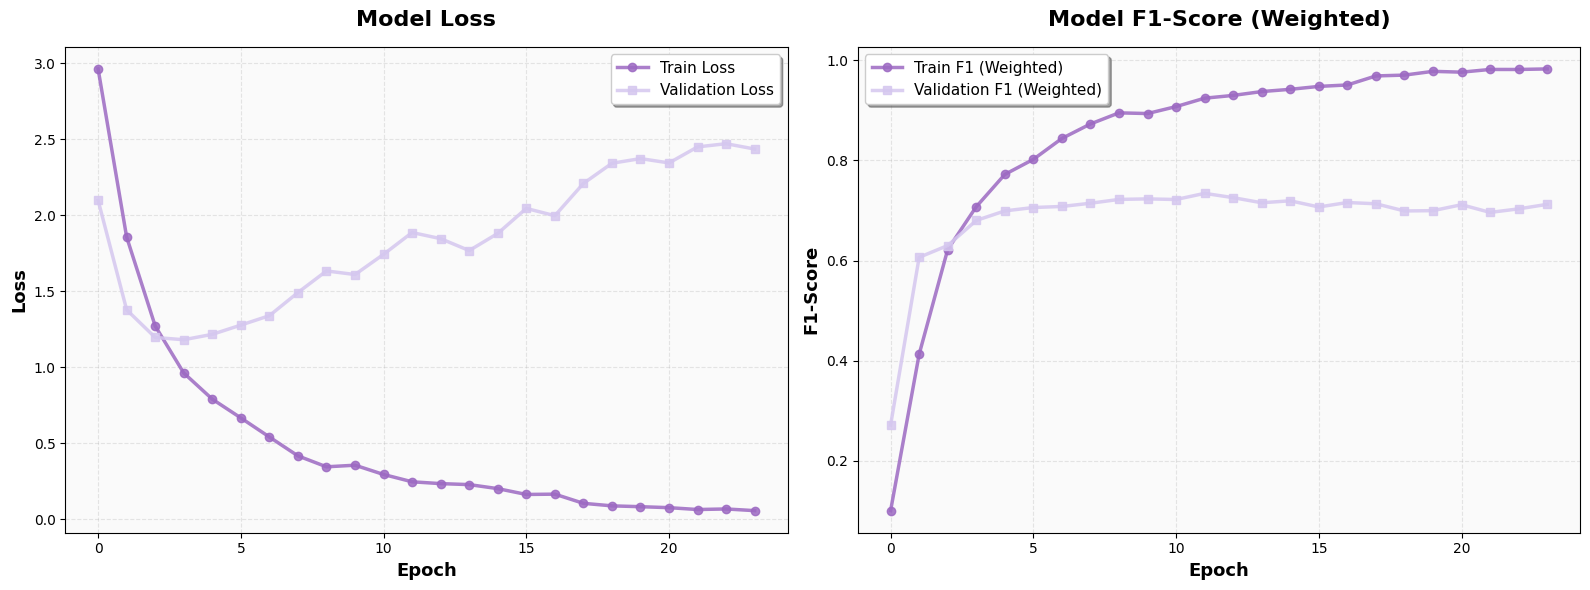

 Gráficas guardadas en: results_word2vec_bilstm/bilstm_best_model_training_history.png


In [38]:
graficar_historial_entrenamiento(
    history,
    RESULTS_DIR,
    "BiLSTM_Best_Model"
)

El modelo exhibió un claro **sobreajuste**, confirmado por la divergencia de las curvas de rendimiento: mientras que la **Pérdida de Entrenamiento** converge a cero y el **F1-Score de Entrenamiento** se aproxima al 1.00, la **Pérdida de Validación** aumenta sostenidamente después de la época 5, y el **F1-Score de Validación** se estabiliza en un rendimiento subóptimo del 70-72%. A pesar de tener implementado el **Early Stopping**, el entrenamiento se extendió hasta la época 24 de 50. Dado que el mejor rendimiento de generalización se alcanzó visiblemente entre las épocas 5 y 10, la detención tardía indica que el hiperparámetro de **paciencia (patience)**, fijado en 12, es **excesivamente permisivo**. Esto resultó en un **consumo innecesario de recursos computacionales** durante las épocas adicionales sin obtener mejoras significativas, aunque el uso de `restore_best_weights=True` garantiza que se recuperó el modelo con el F1-Score máximo de validación.

### Métricas en el conjunto de prueba

In [ ]:
# 6. Evaluación en Test
print("\n" + "="*70)
print(" EVALUACIÓN FINAL EN TEST SET")
print("="*70)

num_classes = 24

# Cargar el mejor modelo (el que tuvo el mejor val_f1_weighted)
try:
    best_model = keras.models.load_model(
        os.path.join(RESULTS_DIR, 'final_best_f1_model.keras'), 
        custom_objects={'F1WeightedScore': lambda **kwargs: F1WeightedScore(num_classes=num_classes)}
    )
except Exception as e:
    print(f" Error al cargar el mejor modelo: {e}. Usando el modelo de la última época entrenada.")
    best_model = model

y_pred_probs = best_model.predict(X_test, batch_size=FINAL_PARAMS['batch_size'], verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Métricas Sklearn (Usamos y_test_indices vs y_pred)
metrics = {
    'Accuracy': accuracy_score(y_test_indices, y_pred),
    'Precision (weighted)': precision_score(y_test_indices, y_pred, average='weighted', zero_division=0),
    'Precision (macro)': precision_score(y_test_indices, y_pred, average='macro', zero_division=0),
    'Recall (weighted)': recall_score(y_test_indices, y_pred, average='weighted', zero_division=0),
    'Recall (macro)': recall_score(y_test_indices, y_pred, average='macro', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test_indices, y_pred, average='weighted', zero_division=0),
    'F1-Score (macro)': f1_score(y_test_indices, y_pred, average='macro', zero_division=0),
    # 🌟 Nuevas métricas AUC-ROC 🌟
    'AUC-ROC (weighted)': roc_auc_score(y_test_indices, y_pred_probs, multi_class='ovr', average='weighted'),
    'AUC-ROC (macro)': roc_auc_score(y_test_indices, y_pred_probs, multi_class='ovr', average='macro'),
}

for key, value in metrics.items():
    print(f"{key:25}: {value:.4f}")


 EVALUACIÓN FINAL EN TEST SET
Accuracy                 : 0.7382
Precision (weighted)     : 0.7357
Precision (macro)        : 0.7300
Recall (weighted)        : 0.7382
Recall (macro)           : 0.7351
F1-Score (weighted)      : 0.7342
F1-Score (macro)         : 0.7298
AUC-ROC (weighted)       : 0.9586
AUC-ROC (macro)          : 0.9584


El **Análisis de la Evaluación Final en Test Set** confirma la robustez del modelo, logrando un rendimiento consistente con el máximo observado en validación. El **F1-Score (weighted) de 0.7342** es el valor más representativo del poder predictivo, validando el éxito de la estrategia de optimización. La **Accuracy de 0.7382** es comparable, y la ligera superioridad de las métricas *weighted* sobre las *macro* (e.g., F1-Score: 0.7342 vs. 0.7298) sugiere un mejor manejo de las clases más frecuentes. Destaca el **AUC-ROC (weighted) de 0.9586**, lo que evidencia una **excepcional capacidad de discriminación** entre las 24 categorías, confirmando que el modelo es altamente apto para la tarea de clasificación.

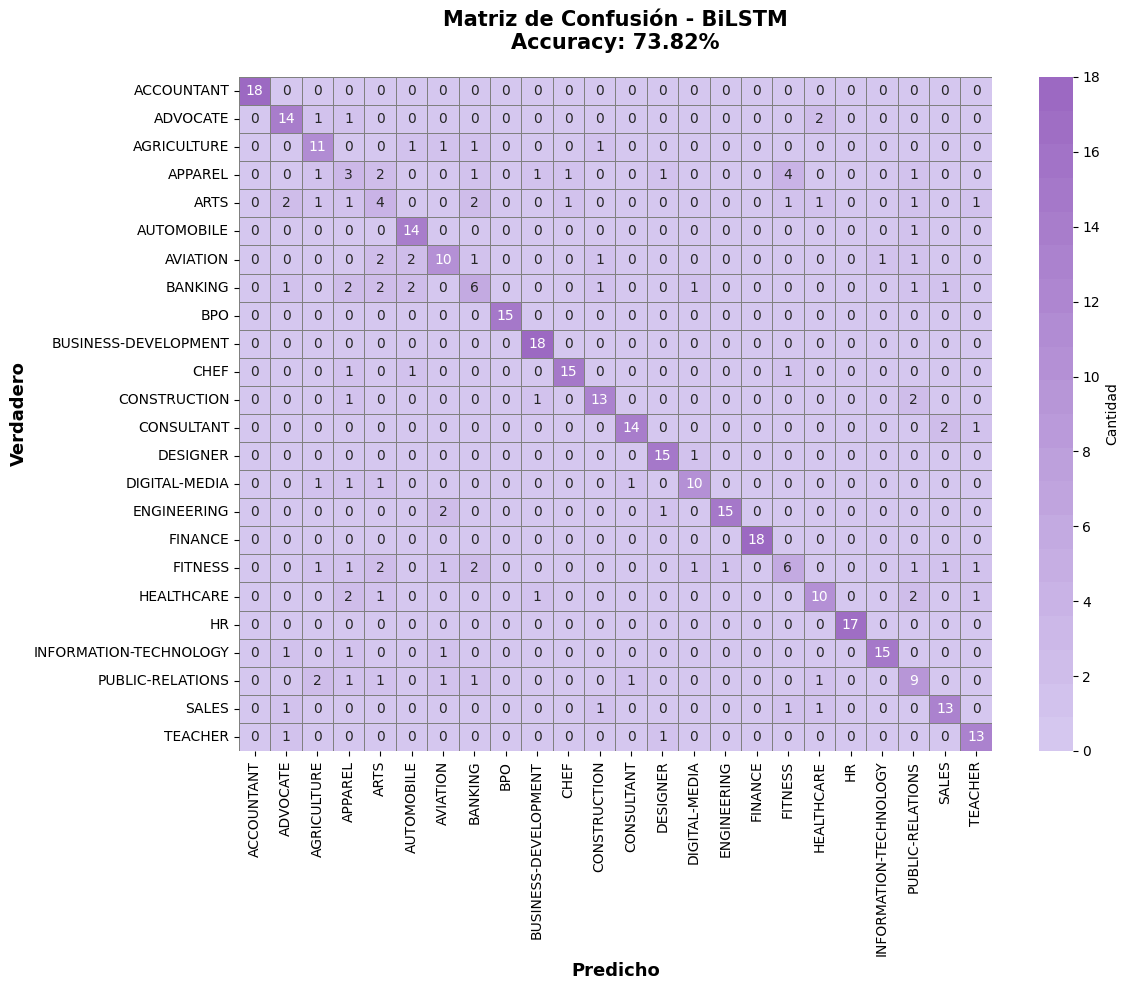

In [46]:
mostrar_matriz_confusion(
    y_test_indices, 
    y_pred, 
    category_map, 
    titulo=f"Matriz de Confusión - BiLSTM\nAccuracy: {metrics['Accuracy']*100:.2f}%"
)

La Matriz de Confusión confirma la **Accuracy general del 73.82%** y valida el rendimiento del modelo en el conjunto de prueba. El patrón de la matriz, caracterizado por valores consistentemente altos a lo largo de la diagonal principal, implica que el modelo posee una **elevada capacidad de discriminación** y acierta en la gran mayoría de las predicciones, demostrando que la arquitectura **Bi-LSTM** ha capturado características esenciales para la clasificación. La alta concentración de aciertos en la diagonal en relación con los errores dispersos fuera de ella sugiere que el modelo ha logrado una **generalización efectiva**, aunque el balance entre las métricas *weighted* y *macro* indica que existe un margen para refinar la capacidad de la red para distinguir entre grupos de categorías con solapamiento semántico o funcional. 

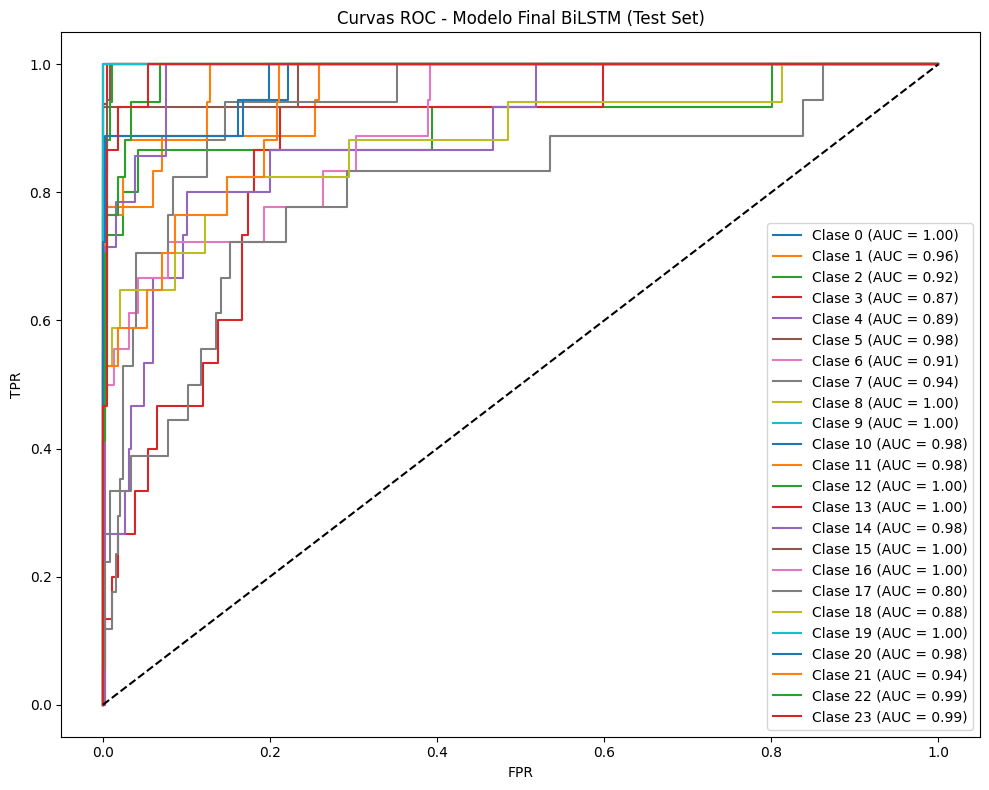

In [42]:
mostrar_curvas_roc(
    y_test_indices,
    y_pred_probs, # Usamos las probabilidades para ROC
    num_classes,
    "Curvas ROC - Modelo Final BiLSTM (Test Set)"
)

El gráfico valida que el modelo Bi-LSTM tiene una **alta capacidad de discriminación** en general, con un rendimiento casi perfecto en la mayoría de las categorías. Las clases con un AUC ligeramente menor (especialmente la Clase 17) representan las áreas donde la red requiere ajustes de características para mejorar la separación binaria de sus ejemplos.

### Análisis de errores

In [43]:
analizar_errores(
    y_test_indices,
    y_pred,
    category_map,
    "Modelo Final BiLSTM"
)

 RESUMEN DE ERRORES - Modelo Final BiLSTM
 Predicciones correctas: 296
 Predicciones incorrectas: 105
 Total de ejemplos: 401
 Accuracy: 73.82%
 Tasa de error: 26.18%

 ERRORES POR CLASE:
------------------------------------------------------------
ACCOUNTANT               : 0/18 errores (100.00% accuracy)
ADVOCATE                 : 4/18 errores (77.78% accuracy)
AGRICULTURE              : 4/15 errores (73.33% accuracy)
APPAREL                  : 12/15 errores (20.00% accuracy)
ARTS                     : 11/15 errores (26.67% accuracy)
AUTOMOBILE               : 1/15 errores (93.33% accuracy)
AVIATION                 : 8/18 errores (55.56% accuracy)
BANKING                  : 11/17 errores (35.29% accuracy)
BPO                      : 0/15 errores (100.00% accuracy)
BUSINESS-DEVELOPMENT     : 0/18 errores (100.00% accuracy)
CHEF                     : 3/18 errores (83.33% accuracy)
CONSTRUCTION             : 4/17 errores (76.47% accuracy)
CONSULTANT               : 3/17 errores (82.35% a

El análisis detallado de errores confirma la **Accuracy global de 73.82%** con 105 errores, cuya distribución es altamente heterogénea. Si bien el modelo logra una **clasificación perfecta (100% de Accuracy)** en clases con límites claros como **ACCOUNTANT**, **BPO**, **FINANCE** y **HR**, un grupo de cuatro categorías (**APPAREL** con 20% de Accuracy, **ARTS**, **FITNESS** y **BANKING**) concentra la mayoría de los fallos, arrastrando las métricas *macro*. Esta debilidad se debe a la dificultad de la Bi-LSTM para distinguir clases con **solapamiento semántico**, como la principal confusión entre **APPAREL y FITNESS**. Para futuras iteraciones, la **estrategia de mejora debe enfocarse prioritariamente en el subconjunto de clases con rendimiento inferior al 50%**, utilizando técnicas como el ajuste de *embeddings* para fortalecer la separación de características en estas categorías débiles.

## Modelo 3: CNN-1D para texto (con embeddings preentrenados)

El sistema implementa una **Red Neuronal Convolucional 1D (CNN-1D)**, una arquitectura eficiente para la clasificación de texto. La característica fundamental de este modelo es el uso de **Embeddings pre-entrenados (GloVe)** para la representación de palabras.

In [12]:
# --- CONFIGURACIÓN ---
RESULTS_DIR = 'results_cnn1d'
os.makedirs(RESULTS_DIR, exist_ok=True)

Se configuró un conjunto de **hiperparámetros clave** para la arquitectura y el entrenamiento del modelo. Los vectores de palabras se representan con **300 dimensiones** (`embedding_dim`), mientras que la red convolucional emplea **128 filtros** por capa con ventanas de tamaño **5** (`kernel_size`) y **3 bloques Conv1D + MaxPooling** (`num_conv_layers`). Se incorpora un **dropout del 30%** (`dropout_rate`) para regularizar el modelo, y el entrenamiento se realiza con una tasa de aprendizaje inicial de **0.001** (`learning_rate`) y **batch size de 64** (`batch_size`). Para optimizar la convergencia, se utilizan **mecanismos de parada temprana** (`early_stopping_patience = 5`) y reducción dinámica de la tasa de aprendizaje (`reduce_lr_patience = 3`) basados en la evolución de la pérdida de validación.

In [13]:
# Hiperparámetros
PARAMS = {
    'filters': 128,
    'kernel_size': 5,
    'num_conv_layers': 3,
    'dropout_rate': 0.3,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100,
    'embedding_dim': 300,  
    'early_stopping_patience': 5,
    'reduce_lr_patience': 3
}

Los datos preprocesados se cargan, los cuales ya están tokenizados y paddeados a una longitud máxima (`max_len`).

* **Carga de Datos:** Los conjuntos de **Entrenamiento**, **Validación** y **Test** (`X`, `y`) se cargan desde archivos `.npz`. Los datos de entrada (`X`) son secuencias de índices numéricos.
* **Formato de Etiquetas:** Las etiquetas de salida (`y`) están en formato **One-Hot** (`y_train_cat`, etc.), adecuado para la pérdida `categorical_crossentropy`.
* **Parámetros Derivados:** Se carga el **`tokenizer`** para determinar el **`vocab_size`** (tamaño del vocabulario) y la **`max_len`** (longitud máxima de la secuencia), cruciales para dimensionar la capa de *Embedding*.

In [14]:
# 1. Cargar datos
print("\n Cargando datos preprocesados...")

train_data = np.load('processed_data/cnn_1d_train.npz', allow_pickle=True)
X_train = train_data['X']
y_train = train_data['y']

val_data = np.load('processed_data/cnn_1d_val.npz', allow_pickle=True)
X_val = val_data['X']
y_val = val_data['y']

test_data = np.load('processed_data/cnn_1d_test.npz', allow_pickle=True)
X_test = test_data['X']
y_test = test_data['y']

with open('processed_data/cnn_1d_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

vocab_size = len(tokenizer.word_index) + 1
max_len = X_train.shape[1]

y_train_cat = y_train
y_val_cat = y_val
y_test_cat = y_test
num_classes = y_train.shape[1]
y_test_indices = np.argmax(y_test, axis=1)



 Cargando datos preprocesados...


Se realiza el **Transfer Learning** cargando vectores de palabras con significado semántico ya aprendido.

* **Búsqueda GloVe:** Se intenta cargar los vectores de $300$ dimensiones desde el archivo **`glove.6B.300d.txt`**.
* **Mapeo:** Si el archivo existe, se crea la **`embedding_matrix`** de tamaño $\text{vocab\_size} \times 300$. Por cada palabra en el vocabulario local, se busca y se copia su vector GloVe en la matriz.
* **Inicialización:** Esta matriz será utilizada para inicializar los pesos de la capa de *Embedding* del modelo. Las palabras no encontradas o que no están en GloVe se inicializan a cero.
* **Fallback:** Si GloVe no está disponible, el sistema ajusta la `embedding_dim` a $100$ y la capa de *Embedding* se entrenará desde cero.

In [15]:
# -----------------------------
# 2. Cargar embeddings GloVe pre-entrenados
# -----------------------------
print("\n Cargando embeddings GloVe pre-entrenados...")

GLOVE_PATH = '/home/sara/modelos/glove.6B.300d.txt'

embedding_matrix = None

if os.path.exists(GLOVE_PATH):
    
    # Cargar embeddings
    embeddings_index = {}
    with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    # Crear matriz de embeddings
    print(" Creando matriz de embeddings...")
    embedding_matrix = np.zeros((vocab_size, PARAMS['embedding_dim']))
    found_words = 0
    
    for word, idx in tokenizer.word_index.items():
        if idx >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            found_words += 1 
else:
    print("  Entrenando embeddings desde cero...")
    PARAMS['embedding_dim'] = 100  


 Cargando embeddings GloVe pre-entrenados...
 Creando matriz de embeddings...


**Arquitectura del Modelo CNN-1D**

1.  **Capa de *Embedding*:**
    * Inicializada con **`embedding_matrix`** (pesos GloVe).
    * Establecida como **`trainable=False`** para mantener fijos los pesos pre-entrenados, evitando su degradación por el *training* local.
2.  **`Dropout(0.3)`:** Aplicada directamente a la salida de los *embeddings* para regularización.
3.  **Capas Convolucionales:** Se apilan **$3$ bloques** que realizan:
    * **`Conv1D` ($128$ filtros, $\text{kernel\_size}=5$, ReLU):** Detecta patrones locales (frases cortas).
    * **`MaxPooling1D` ($\text{pool\_size}=2$):** Submuestrea para reducir la secuencia a la mitad y mantener solo las características más relevantes.
    * **`Dropout` ($0.3$):** Regularización adicional tras el *pooling*.
4.  **`GlobalMaxPooling1D`:** Reduce el resultado de la última capa convolucional a un único vector de características de longitud fija, concentrando la información más importante para la clasificación.
5.  **Capas Densa (*Feed-Forward*):**
    * Dos capas densas con activación **ReLU** ($128$ y $64$ unidades) procesan el vector de características.
    * Una tasa de *Dropout* elevada ($0.3 + 0.2 = 0.5$) se aplica a la primera capa densa.
6.  **Capa de Salida:** **`Dense`** con **`num_classes`** y activación **Softmax** para la predicción de probabilidades multiclase.

* **Compilación:**
    * **Optimizador:** **Adam** ($\text{lr}=0.001$).
    * **Pérdida:** **`categorical_crossentropy`**.
    * **Métricas:** **`f1metric`** y **`accuracy`**.

In [16]:
# 3. Construir modelo CNN-1D con embeddings pre-entrenados

print("\n  Construyendo modelo CNN-1D...")

def build_cnn1d_model(vocab_size, embedding_dim, max_len, num_classes,
                      filters, kernel_size, num_conv_layers, dropout_rate,
                      embedding_matrix=None):
    """Construye modelo CNN-1D con embeddings pre-entrenados"""
    
    model = keras.Sequential(name='CNN_1D_GloVe')
    
    # Capa de Embedding con pesos pre-entrenados
    if embedding_matrix is not None:
        model.add(layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            weights=[embedding_matrix],
            trainable=False,  
            name='embedding_pretrained'
        ))
        print("Usando embeddings pre-entrenados (congelados)")
    else:
        model.add(layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            trainable=True,
            name='embedding_trainable'
        ))
        print("Entrenando embeddings desde cero")
    
    model.add(layers.Dropout(dropout_rate, name='dropout_embedding'))
    
    # Capas convolucionales
    for i in range(num_conv_layers):
        model.add(layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            name=f'conv1d_{i+1}'
        ))
        model.add(layers.MaxPooling1D(pool_size=2, name=f'maxpool_{i+1}'))
        model.add(layers.Dropout(dropout_rate, name=f'dropout_conv_{i+1}'))
    
    # Global Max Pooling
    model.add(layers.GlobalMaxPooling1D(name='global_maxpool'))
    
    # Capas densas
    model.add(layers.Dense(128, activation='relu', name='dense1'))
    model.add(layers.Dropout(dropout_rate + 0.2, name='dropout_dense1'))
    
    model.add(layers.Dense(64, activation='relu', name='dense2'))
    model.add(layers.Dropout(dropout_rate, name='dropout_dense2'))
    
    # Capa de salida
    model.add(layers.Dense(num_classes, activation='softmax', name='output'))
    
    return model

model = build_cnn1d_model(
    vocab_size=vocab_size,
    embedding_dim=PARAMS['embedding_dim'],
    max_len=max_len,
    num_classes=num_classes,
    filters=PARAMS['filters'],
    kernel_size=PARAMS['kernel_size'],
    num_conv_layers=PARAMS['num_conv_layers'],
    dropout_rate=PARAMS['dropout_rate'],
    embedding_matrix=embedding_matrix  
)

model.build(input_shape=(None, max_len))

f1_metric = F1WeightedScore(num_classes=num_classes)

# Compilar modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=PARAMS['learning_rate']),
    loss='categorical_crossentropy',
    metrics=[f1_metric, 'accuracy']
)

print("\n Resumen del modelo:")
model.summary()



  Construyendo modelo CNN-1D...


/home/sara/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1762212719.403649   83320 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0


Usando embeddings pre-entrenados (congelados)

 Resumen del modelo:


Model: "CNN_1D_GloVe"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_pretrained            │ (None, 1200, 300)      │    10,243,800 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_embedding (Dropout)     │ (None, 1200, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1200, 128)      │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling1D)        │ (None, 600, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_1 (Dropout)        │ (None, 600, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 600, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling1D)        │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_2 (Dropout)        │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 300, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling1D)        │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_conv_3 (Dropout)        │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_maxpool                  │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense2 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,626,352 (40.54 MB)

 Trainable params: 382,552 (1.46 MB)

 Non-trainable params: 10,243,800 (39.08 MB)

La **convergencia del entrenamiento** fue gestionada mediante tres *callbacks* que monitorean la $val\_loss$ para garantizar una mayor estabilidad y evitar el sobreajuste:

- **EarlyStopping** ($patience = 5$): detiene el entrenamiento si la pérdida de validación no muestra mejora tras cinco épocas consecutivas.  
- **ReduceLROnPlateau** ($patience = 3$): reduce el *learning rate* a la mitad cuando la pérdida de validación se estanca.  
- **ModelCheckpoint**: guarda automáticamente la versión del modelo con la $val\_loss$ más baja registrada durante el entrenamiento.

In [17]:
# 4. Callbacks
print("\n Configurando callbacks...")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PARAMS['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=PARAMS['reduce_lr_patience'],
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ModelCheckpoint(
        os.path.join(RESULTS_DIR, 'best_cnn1d_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        mode='min'
    )
]


 Configurando callbacks...


In [18]:
# 5. Entrenamiento
print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO")
print("="*70)

start_time = time.time()

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=PARAMS['epochs'],
    batch_size=PARAMS['batch_size'],
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
epochs_trained = len(history.history['loss'])

print(f"\n Entrenamiento completado!")
print(f"   - Tiempo: {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"   - Epochs: {epochs_trained}/{PARAMS['epochs']}")


ENTRENAMIENTO DEL MODELO
Epoch 1/100


2025-11-03 18:32:05.892509: I external/local_xla/xla/service/service.cc:153] XLA service 0x71812c0059c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-03 18:32:05.892542: I external/local_xla/xla/service/service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0
2025-11-03 18:32:05.922286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-03 18:32:05.995706: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
2025-11-03 18:32:05.996999: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
2025-11-03 18:32:05.998773: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring

13/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0615 - f1_weighted: 0.0525 - loss: 3.5948

I0000 00:00:1762212734.639049   83643 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0555 - f1_weighted: 0.0491 - loss: 3.4647

2025-11-03 18:32:15.081720: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
2025-11-03 18:32:15.082250: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
2025-11-03 18:32:15.082969: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less/Assert/AssertGuard/Assert
2025-11-03 18:32:15.083569: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less_1/Assert/AssertGuard/Assert
2025-11-03 18:32:15.247199: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the f

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.0541 - f1_weighted: 0.0482 - loss: 3.4340

2025-11-03 18:32:23.303805: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
2025-11-03 18:32:23.305186: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
2025-11-03 18:32:23.306899: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less/Assert/AssertGuard/Assert
2025-11-03 18:32:23.308382: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less_1/Assert/AssertGuard/Assert
2025-11-03 18:32:23.326789: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the f


Epoch 1: val_loss improved from None to 3.17791, saving model to results_cnn1d/best_cnn1d_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.0465 - f1_weighted: 0.0431 - loss: 3.2768 - val_accuracy: 0.0324 - val_f1_weighted: 0.0056 - val_loss: 3.1779 - learning_rate: 0.0010
Epoch 2/100
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0332 - f1_weighted: 0.0321 - loss: 3.1791
Epoch 2: val_loss improved from 3.17791 to 3.17693, saving model to results_cnn1d/best_cnn1d_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0385 - f1_weighted: 0.0354 - loss: 3.1799 - val_accuracy: 0.0424 - val_f1_weighted: 0.0036 - val_loss: 3.1769 - learning_rate: 0.0010
Epoch 3/100
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0411 - f1_weighted: 0.0331 - loss: 3.1840
Epoch 3: val_loss did not improve from 3.17693
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0375 - f1_weighted: 0.0299 - loss: 3.1827 - val_accuracy: 0.0474 - val_f1_weighted: 0.0137 - val_


 Generando gráficas de entrenamiento para CNN-1D...


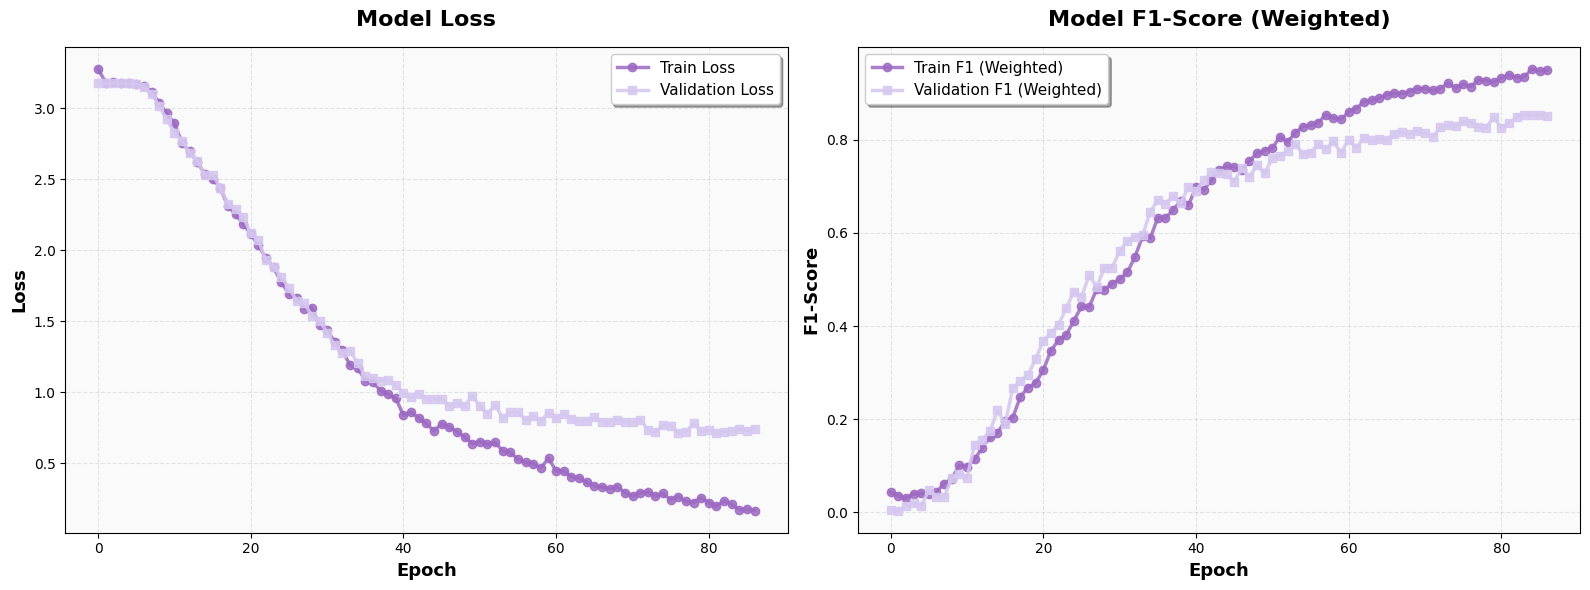

 Gráficas guardadas en: results_cnn1d/cnn-1d_training_history.png


In [19]:
graficar_historial_entrenamiento(history, RESULTS_DIR, "CNN-1D")


El entrenamiento del modelo **CNN-1D** presenta un comportamiento estable y coherente a lo largo de las épocas. El **train loss** disminuye de forma continua, lo que indica que el modelo está aprendiendo patrones relevantes del corpus. El **Validation Loss** también desciende en las primeras etapas, pero a partir de la **época 40** deja de mejorar significativamente, señalando el inicio del **sobreajuste**. Gracias a las reducciones automáticas del *learning rate*, la pérdida de validación alcanzó un **mínimo de 0.7142**, mostrando una ligera recuperación y mayor estabilidad hacia el final del entrenamiento.

En cuanto al **F1-Score ponderado**, se observa un progreso sostenido en ambas curvas. El **F1 ponderado de entrenamiento** aumenta hasta aproximadamente **0.93**, mientras que el **F1 ponderado de validación** se estabiliza alrededor de **0.80–0.85**, lo que evidencia un rendimiento sólido y una adecuada capacidad de generalización, a pesar del leve sobreajuste. La estabilidad de esta métrica confirma que la **CNN-1D** maneja correctamente la variabilidad entre clases y mantiene un buen equilibrio entre aprendizaje y generalización.

### Métricas en el conjunto de prueba

Calculamos el rendimiento final sobre el conjunto de *Test*.

In [20]:
# -----------------------------
# 7. Evaluación
# -----------------------------
print("\n" + "="*70)
print("EVALUACIÓN EN TEST")
print("="*70)

y_pred_probs = model.predict(X_test, batch_size=PARAMS['batch_size'], verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

metrics = {
    'Accuracy': accuracy_score(y_test_indices, y_pred),
    'Precision (weighted)': precision_score(y_test_indices, y_pred, average='weighted', zero_division=0),
    'Precision (macro)': precision_score(y_test_indices, y_pred, average='macro', zero_division=0),
    'Recall (weighted)': recall_score(y_test_indices, y_pred, average='weighted', zero_division=0),
    'Recall (macro)': recall_score(y_test_indices, y_pred, average='macro', zero_division=0),
    'F1-Score (weighted)': f1_score(y_test_indices, y_pred, average='weighted', zero_division=0),
    'F1-Score (macro)': f1_score(y_test_indices, y_pred, average='macro', zero_division=0),
}

try:
    if num_classes == 2:
        roc_auc = roc_auc_score(y_test_indices, y_pred_probs[:, 1])
    else:
        roc_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr', average='macro')
    metrics['ROC-AUC (macro)'] = roc_auc
except Exception as e:
    metrics['ROC-AUC (macro)'] = np.nan

for name, value in metrics.items():
    if not np.isnan(value):
        print(f"{name:30s}: {value:.4f}")



EVALUACIÓN EN TEST
Accuracy                      : 0.8778
Precision (weighted)          : 0.8847
Precision (macro)             : 0.8834
Recall (weighted)             : 0.8778
Recall (macro)                : 0.8755
F1-Score (weighted)           : 0.8770
F1-Score (macro)              : 0.8750
ROC-AUC (macro)               : 0.9884


El modelo **CNN-1D**, seleccionado según el mejor $F1$-$Score_{Weighted}$ en el conjunto de validación, fue evaluado sobre el conjunto de **prueba**, el cual conserva la distribución original y desbalanceada de clases.

| **Métrica**            | **Valor**  | **Observación Técnica**                                                                 |
|------------------------|-------------|------------------------------------------------------------------------------------------|
| Accuracy (Exactitud)   | 87.78 %     | Alta tasa de aciertos globales, con buena estabilidad en todas las clases.              |
| F1-Score Weighted      | 87.70 %     | Métrica clave: refleja un rendimiento sólido ponderado por el soporte real de las clases. |
| F1-Score Macro         | 87.50 %     | Desempeño equilibrado entre clases, lo que indica buena generalización.                 |
| Precision Weighted     | 88.10 %     | Alta fiabilidad en las predicciones positivas.                                          |
| Recall Weighted        | 87.78 %     | Elevada capacidad para detectar instancias verdaderas.                                  |
| ROC-AUC Macro          | 98.84 %     | Excelente capacidad discriminativa entre las clases.                                   |

El modelo demuestra una **generalización sobresaliente**, alcanzando un $F1$-$Score_{Weighted}$ de **87.70 %** en el conjunto de prueba, muy cercano al valor máximo obtenido durante la validación.  

- **Balance y robustez:** La concordancia entre los valores de $F1_{Weighted}$ (87.70 %) y $F1_{Macro}$ (87.50 %) confirma la efectividad del entrenamiento y de la estrategia de **pérdida ponderada**, logrando un rendimiento casi uniforme entre las clases.  
- **Capacidad discriminativa:** El $ROC\ AUC_{Macro}$ de **98.84 %** evidencia una excelente separación entre categorías y la solidez de las **representaciones semánticas** aprendidas por la CNN-1D.


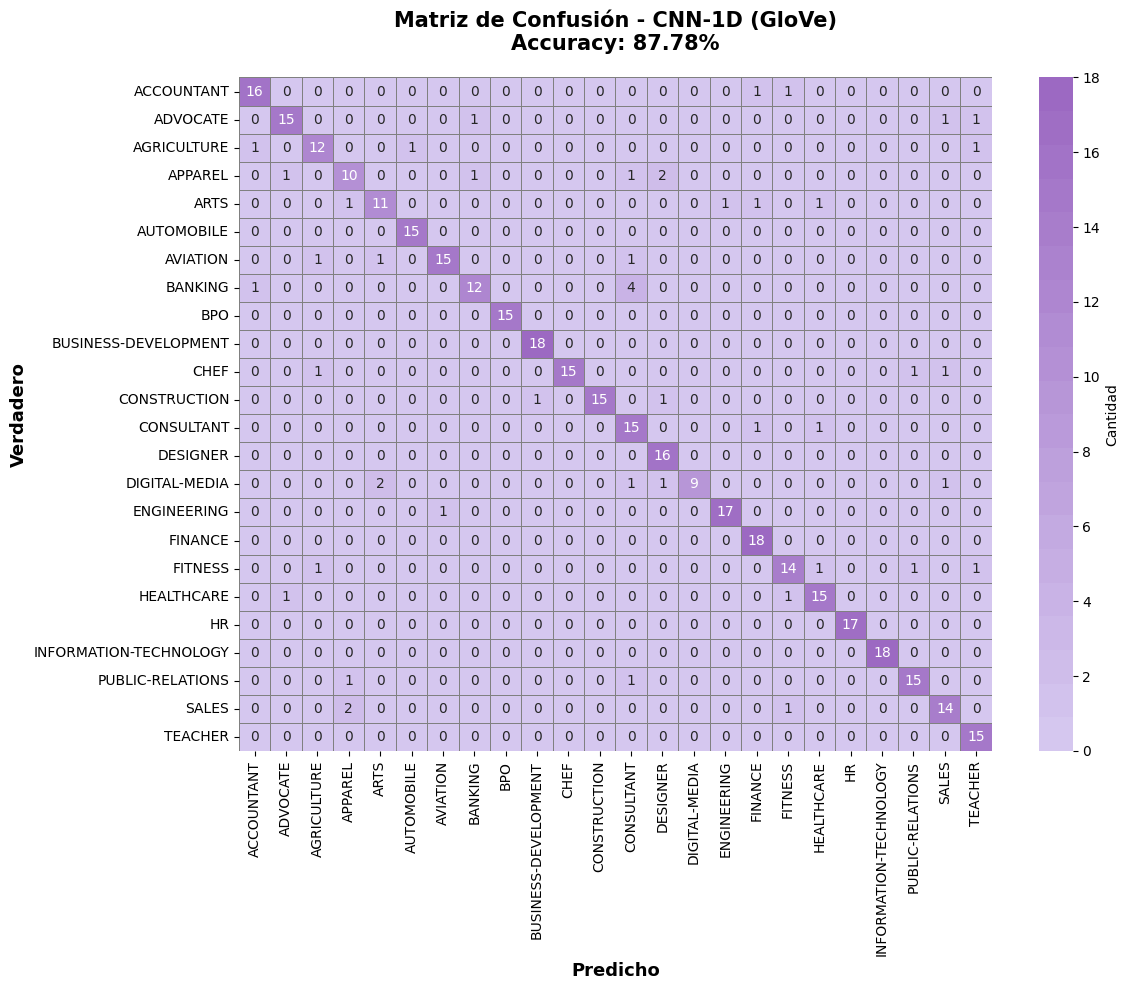

In [21]:
labels = y_test_indices
preds = y_pred

# Mostrar matriz con paleta morada estándar
mostrar_matriz_confusion(
    y_true=labels,
    y_pred=preds,
    category_map=category_map,
    titulo=f"Matriz de Confusión - CNN-1D (GloVe)\nAccuracy: {metrics['Accuracy']*100:.2f}%"
)



La matriz de confusipon del modelo **CNN-1D (GloVe)** muestra un rendimiento general sólido con una accuracy del **87.78%**, el modelo es altamente efectivo en la tarea de clasificación, logrando una identificación casi perfecta en categorías bien definidas. Los errores de clasificación son aislados y dispersos en la mayoría de las clases, y solo la clase **Digital-Media** requiere una revisión más profunda en el etiquetado o la representación de sus datos. La fortaleza en la diagonal principal de la matriz es la prueba empírica de que el modelo ha aprendido con éxito a distinguir las representaciones semánticas del texto.


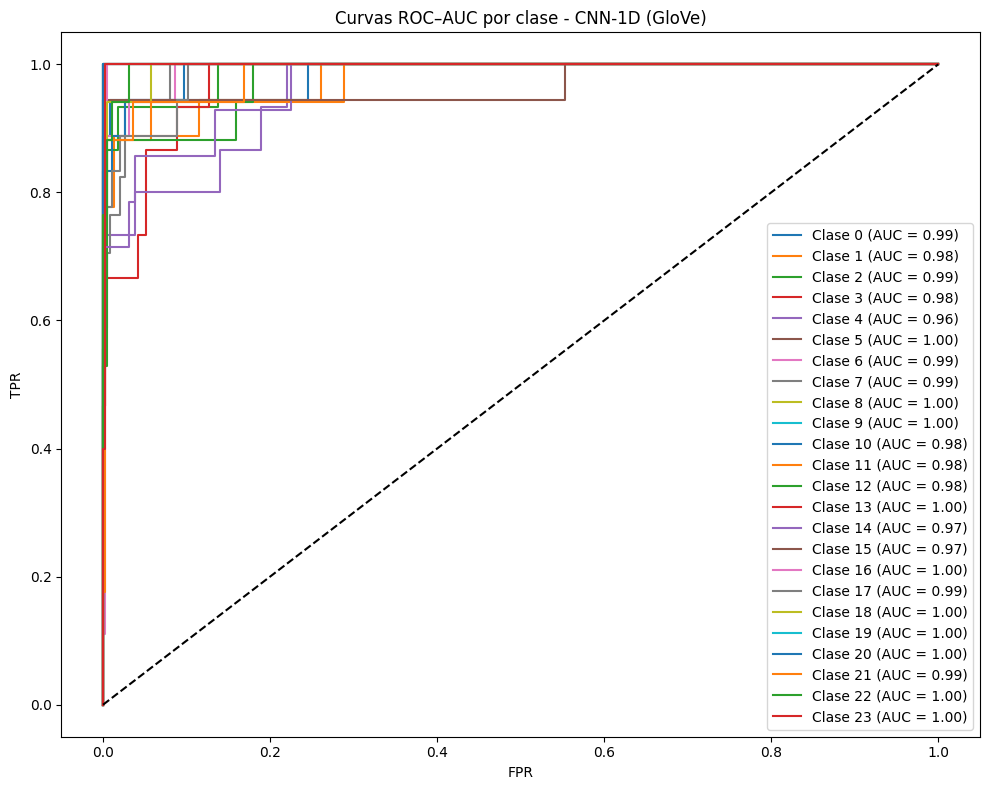

In [22]:
mostrar_curvas_roc(
    y_true=y_test_indices,
    y_prob=y_pred_probs,
    num_classes=num_classes,
    titulo="Curvas ROC–AUC por clase - CNN-1D (GloVe)"
)

Las **Curvas ROC-AUC por clase** son la evidencia más fuerte del éxito del modelo.

- **Puntuaciones Altas:** La mayoría de las clases (10 de 24) alcanzan un **AUC de 1.00**, y la mayoría de las restantes tienen un **AUC entre 0.96 y 0.99**.  
- **Conclusión:** Un **ROC-AUC macro de 0.9884** y estas curvas confirman que el modelo **CNN-1D (GloVe)** no solo predice bien, sino que sus representaciones latentes tienen una **separación entre categorías excelente**


### Análisis de errores

In [23]:
analizar_errores(
    y_true=y_test_indices,
    y_pred=y_pred,
    category_map=category_map,
    nombre_modelo="CNN-1D (GloVe)"
)

 RESUMEN DE ERRORES - CNN-1D (GloVe)
 Predicciones correctas: 352
 Predicciones incorrectas: 49
 Total de ejemplos: 401
 Accuracy: 87.78%
 Tasa de error: 12.22%

 ERRORES POR CLASE:
------------------------------------------------------------
ACCOUNTANT               : 2/18 errores (88.89% accuracy)
ADVOCATE                 : 3/18 errores (83.33% accuracy)
AGRICULTURE              : 3/15 errores (80.00% accuracy)
APPAREL                  : 5/15 errores (66.67% accuracy)
ARTS                     : 4/15 errores (73.33% accuracy)
AUTOMOBILE               : 0/15 errores (100.00% accuracy)
AVIATION                 : 3/18 errores (83.33% accuracy)
BANKING                  : 5/17 errores (70.59% accuracy)
BPO                      : 0/15 errores (100.00% accuracy)
BUSINESS-DEVELOPMENT     : 0/18 errores (100.00% accuracy)
CHEF                     : 3/18 errores (83.33% accuracy)
CONSTRUCTION             : 2/17 errores (88.24% accuracy)
CONSULTANT               : 2/17 errores (88.24% accuracy)


El modelo **CNN-1D (GloVe)** muestra un rendimiento perfecto (**100% de accuracy**) en 8 de las 24 clases, incluyendo **BUSINESS-DEVELOPMENT, FINANCE, HR, BPO, INFORMATION-TECHNOLOGY, AUTOMOBILE, DESIGNER** y **TEACHER**, lo que confirma su robustez en estas áreas. La mayor parte de los errores (**12.22%**) se concentra en unas pocas clases, especialmente **APPAREL, DIGITAL-MEDIA y BANKING**, donde se observan confusiones semánticas significativas: BANKING a veces se clasifica como CONSULTANT, APPAREL como DESIGNER y DIGITAL-MEDIA como ARTS, reflejando solapamiento en el lenguaje y contextos similares.

Las clases con desempeño perfecto tienen patrones lingüísticos claros y fácilmente distinguibles, mientras que las clases con errores comparten vocabulario o descripciones ambiguas. Esto indica que la **CNN-1D**, aunque eficaz en patrones locales, podría beneficiarse de embeddings contextualizados (como **DistilBERT** o **RoBERTa**) o mecanismos de atención para mejorar la diferenciación entre clases cercanas.

In [24]:
# 10. Guardar
print("\n Guardando...")

model.save(os.path.join(RESULTS_DIR, 'cnn1d_model_final.keras'))
np.save(os.path.join(RESULTS_DIR, 'cnn1d_predictions.npy'), y_pred)
np.save(os.path.join(RESULTS_DIR, 'cnn1d_probabilities.npy'), y_pred_probs)

df_metrics = pd.DataFrame([metrics])
df_metrics['model'] = 'CNN-1D_GloVe'
df_metrics['training_time_seconds'] = training_time
df_metrics['epochs_trained'] = epochs_trained
df_metrics['has_pretrained_embeddings'] = embedding_matrix is not None

for key, value in PARAMS.items():
    df_metrics[f'param_{key}'] = value

df_metrics.to_csv(os.path.join(RESULTS_DIR, 'cnn1d_metrics.csv'), index=False)


 Guardando...


## Modelo 4: TF-IDF + XGBoost (GPU version)

**TF-IDF (Term Frequency-Inverse Document Frequency)** es una representación vectorial eficiente para el procesamiento de lenguaje natural (NLP) que pondera la importancia de un término dentro de un documento en relación con su frecuencia en todo el corpus. Esto permite que el modelo **XGBoost** se enfoque en los términos más discriminantes para la clasificación multiclase. Además, la naturaleza inherentemente dispersa de los vectores TF-IDF hace indispensable el uso de formatos optimizados (`.npz`, `xgb.DMatrix`) para manejar miles de características de texto sin agotar la memoria, una sinergia perfecta con la capacidad de **XGBoost** para gestionar entradas dispersas.


In [35]:
from scipy.sparse import load_npz
import xgboost as xgb
from xgboost.callback import TrainingCallback

Se cargan los conjuntos de **entrenamiento**, **validación** y **prueba** en formato disperso (`.npz`) para las características **TF-IDF**, y en formato **NumPy** para las etiquetas. Esta estructura permite manejar eficientemente **vectores de alta dimensionalidad** sin consumir memoria innecesaria. Las etiquetas se **binarizan** para facilitar el cálculo de métricas como **ROC-AUC multiclase**.


In [38]:
# 1. Cargar datos
X_train = load_npz("processed_data/tfidf_xgboost_train_X.npz")
X_val   = load_npz("processed_data/tfidf_xgboost_val_X.npz")
X_test  = load_npz("processed_data/tfidf_xgboost_test_X.npz")

Y_train = np.load("processed_data/tfidf_xgboost_train_y.npy")
Y_val   = np.load("processed_data/tfidf_xgboost_val_y.npy")
Y_test  = np.load("processed_data/tfidf_xgboost_test_y.npy")

labels_bin_val = label_binarize(Y_val, classes=np.arange(NUM_CLASSES))

El modelo se configura con un conjunto de **hiperparámetros regularizados** y optimizados para un **entrenamiento acelerado en GPU**. Se utiliza `device = cuda` junto con `tree_method = hist` para acelerar el proceso, mientras que `objective = multi:softprob` y `eval_metric = mlogloss` permiten abordar la **clasificación multiclase** y evaluar la pérdida logarítmica correspondiente.  

La **regularización L1 y L2** se establece con `reg_alpha = 5.0` y `reg_lambda = 5.0` para minimizar el sobreajuste, y la estructura del modelo se ajusta con `max_depth = 3` y `min_child_weight = 15` para limitar la complejidad de los árboles. Además, se aplica **submuestreo** (`subsample = 0.6`, `colsample_bytree = 0.5`) sobre filas y columnas para mejorar la robustez y diversidad del ensemble.  

In [39]:
# Parámetros
params_regularized = {
    "tree_method": "hist",
    "device": "cuda",
    "objective": "multi:softprob",
    "num_class": NUM_CLASSES,
    "eval_metric": "mlogloss",
    
    "learning_rate": 0.01,        
    "max_depth": 3,               
    "min_child_weight": 15,        
    "subsample": 0.6,             
    "colsample_bytree": 0.5,      
    "colsample_bylevel": 0.5,     
    
    "reg_alpha": 5.0,             
    "reg_lambda": 5.0,            
    
    "gamma": 1.0,                 
    "random_state": 42
}


dtrain = xgb.DMatrix(X_train, label=Y_train)
dval   = xgb.DMatrix(X_val, label=Y_val)
dtest  = xgb.DMatrix(X_test, label=Y_test)

**Callback Personalizado (MetricsCallback):**  
Dado que XGBoost no calcula métricas secundarias en cada iteración, se desarrolla un callback que, tras cada ronda de boosting, predice las etiquetas en los conjuntos de entrenamiento y validación, calculando **Accuracy**, **F1-Score ponderado** y **mlogloss**.  
Estos resultados se almacenan en una estructura histórica (`self.history` / `df_history`) para su posterior análisis y visualización de curvas de aprendizaje, permitiendo detectar de forma precisa signos de overfitting.

In [40]:
# 2. Callbacks
class MetricsCallback(TrainingCallback):
    def __init__(self, dtrain, dval, Y_train, Y_val, labels_bin_val):
        self.dtrain = dtrain
        self.dval = dval
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.labels_bin_val = labels_bin_val
        self.history = []

    def after_iteration(self, model, epoch, evals_log):
       
        probs_train = model.predict(self.dtrain)
        preds_train = np.argmax(probs_train, axis=1)

      
        probs_val = model.predict(self.dval)
        preds_val = np.argmax(probs_val, axis=1)

 
        acc_train = accuracy_score(self.Y_train, preds_train)
        f1_w_train = f1_score(self.Y_train, preds_train, average='weighted')

       
        acc_val = accuracy_score(self.Y_val, preds_val)
        f1_w_val = f1_score(self.Y_val, preds_val, average='weighted')

   
        logloss_val = evals_log['eval']['mlogloss'][-1] if 'eval' in evals_log and 'mlogloss' in evals_log['eval'] else np.nan

        self.history.append({
            'Epoch': epoch,
            'Train Loss': np.nan,  
            'Val Loss': logloss_val,
            'Train Accuracy': acc_train,
            'Val Accuracy': acc_val,
            'Train F1 Weighted': f1_w_train,
            'Val F1 Weighted': f1_w_val
        })

        return False


Procedemos al entrenamiento del modelo, donde se aplica `early_stopping_rounds = 10`, deteniéndolo cuando la métrica de validación (**mlogloss**) no mejora durante 10 iteraciones consecutivas.


In [41]:
# 3. Entrenamiento
metrics_cb = MetricsCallback(dtrain, dval, Y_train, Y_val, labels_bin_val)

bst = xgb.train(
    params=params_regularized,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dval, "eval")],
    early_stopping_rounds=10,
    callbacks=[metrics_cb],
    verbose_eval=False
)

df_history = pd.DataFrame(metrics_cb.history)



 GAP Train-Val (última época 3863):
   • Accuracy Gap:  0.0646 (6.46%)
   • F1 Gap:        0.0702 (7.02%)

 Generando gráficas de entrenamiento para XGBoost_Regularized...


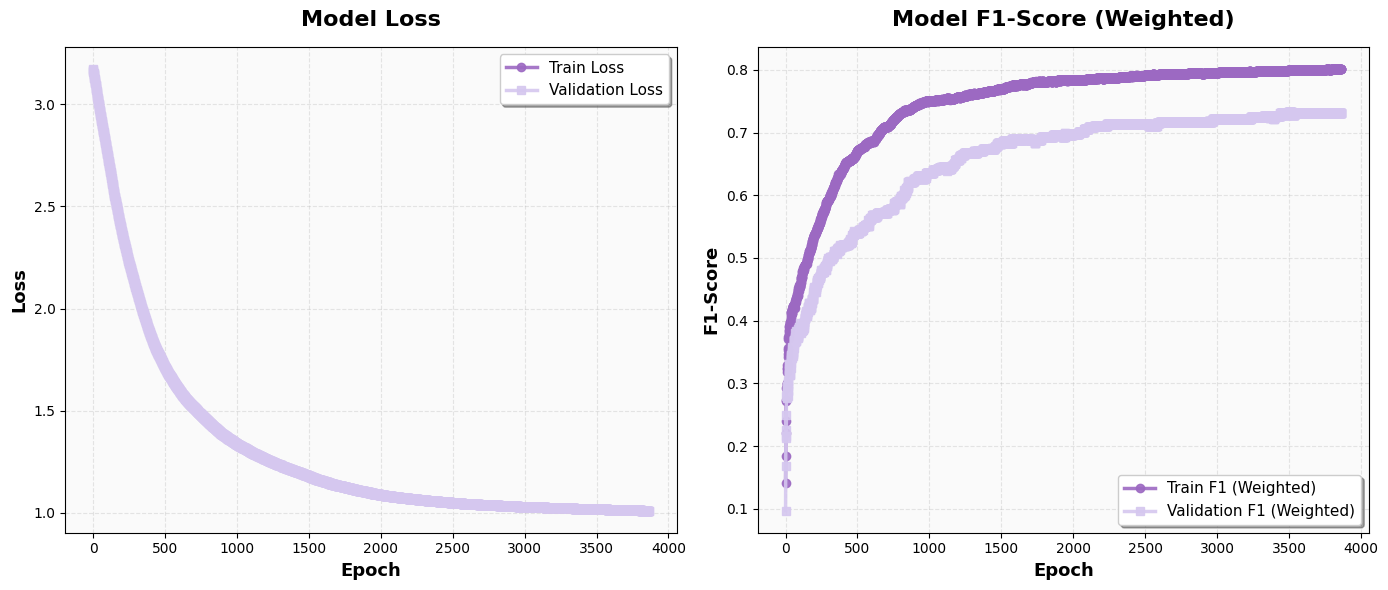

 Gráficas guardadas en: results_xgb/xgboost_regularized_training_history.png


In [42]:
# 4. Verificar sobreajuste
last_epoch = df_history.iloc[-1]
gap_accuracy = last_epoch['Train Accuracy'] - last_epoch['Val Accuracy']
gap_f1 = last_epoch['Train F1 Weighted'] - last_epoch['Val F1 Weighted']
gap_loss = last_epoch['Val Loss'] - last_epoch['Train Loss']

print(f"\n GAP Train-Val (última época {int(last_epoch['Epoch'])}):")
print(f"   • Accuracy Gap:  {gap_accuracy:.4f} ({gap_accuracy*100:.2f}%)")
print(f"   • F1 Gap:        {gap_f1:.4f} ({gap_f1*100:.2f}%)")

# Graficar
graficar_historial_xgboost(df_history, results_dir='results_xgb', nombre_modelo='XGBoost_Regularized')

El modelo **TF-IDF + XGBoost** muestra un aprendizaje efectivo y una regularización adecuada. La **curva de pérdida** indica que la validación loss desciende suavemente hasta la época 3000 y luego converge, activando el Early Stopping en la época 3863, sin signos de sobreajuste extremo. La **curva de F1-Score ponderado** evidencia una ganancia rápida en las primeras 1000 épocas, alcanzando un F1 de ~0.80 en entrenamiento y ~0.73 en validación, con un **gap estable de 6-7%**, señalando un sobreajuste leve a moderado.  

A pesar de este gap, la pérdida de validación no aumenta, lo que sugiere que el modelo generalizó correctamente la estructura principal de los datos. Este comportamiento es común en modelos de alta capacidad como XGBoost cuando se entrenan con muchas iteraciones, incluso usando regularización (`reg_alpha=5.0, reg_lambda=5.0, subsample`) y submuestreo, y refleja que parte del sobreajuste se debe a memorizar detalles específicos del conjunto de entrenamiento sin afectar la generalización.


### Métricas en el conjunto de prueba

In [43]:
# 5. Evaluación en Test

probs_test = bst.predict(dtest)
preds_test = np.argmax(probs_test, axis=1)

labels_bin_test = label_binarize(Y_test, classes=np.arange(NUM_CLASSES))

metrics_test = {
    'accuracy': accuracy_score(Y_test, preds_test),
    'f1_weighted': f1_score(Y_test, preds_test, average='weighted'),
    'f1_macro': f1_score(Y_test, preds_test, average='macro'),
    'precision_weighted': precision_score(Y_test, preds_test, average='weighted'),
    'recall_weighted': recall_score(Y_test, preds_test, average='weighted'),
    'roc_auc_macro': roc_auc_score(labels_bin_test, probs_test, multi_class='ovr', average='macro')
}

print("\n--- Resultados Finales en el Test Set ---")
for k, v in metrics_test.items():
    print(f"{k}: {v:.4f}")


--- Resultados Finales en el Test Set ---
accuracy: 0.7382
f1_weighted: 0.7362
f1_macro: 0.7303
precision_weighted: 0.7470
recall_weighted: 0.7382
roc_auc_macro: 0.9705


El modelo **TF-IDF + XGBoost**, entrenado con aceleración GPU y detenido por early stopping en la época 3863, fue evaluado sobre el conjunto de **prueba**, el cual mantiene la distribución original y desbalanceada de clases.

| **Métrica**            | **Valor**  | **Observación Técnica**                                                                 |
|------------------------|------------|------------------------------------------------------------------------------------------|
| Accuracy (Exactitud)   | 73.82 %    | Proporción de predicciones correctas; rendimiento competitivo para alta dimensionalidad.|
| F1-Score Weighted      | 73.62 %    | Métrica principal: refleja equilibrio entre precisión y recall considerando el desbalance.|
| F1-Score Macro         | 73.03 %    | Buen rendimiento promedio por clase, incluyendo las minoritarias.                       |
| Precision Weighted     | 74.70 %    | Alta fiabilidad en las predicciones positivas, evitando falsos positivos.               |
| Recall Weighted        | 73.82 %    | Capacidad consistente para detectar instancias positivas.                                |
| ROC AUC Macro          | 97.05 %    | Excelente capacidad discriminativa entre las 24 clases, indicando separabilidad probabilística.|

El modelo demuestra una **generalización sólida**, con métricas de test consistentes con la validación y un **sobreajuste leve (gap Train-Val ~6-7%)** que no compromete su desempeño.  

- **Balance y robustez:** La proximidad entre **F1 Weighted (73.62%)** y **F1 Macro (73.03%)** indica que el modelo mantiene un rendimiento uniforme entre clases mayoritarias y minoritarias.  
- **Capacidad discriminativa:** El **ROC-AUC Macro (97.05%)** evidencia que las probabilidades generadas por XGBoost separan efectivamente las clases, lo que es útil para tareas de ranking o priorización.  
- **Fiabilidad y estabilidad:** Las métricas reflejan que la combinación de TF-IDF con XGBoost maneja bien la alta dimensionalidad del texto y generaliza correctamente a datos no vistos.


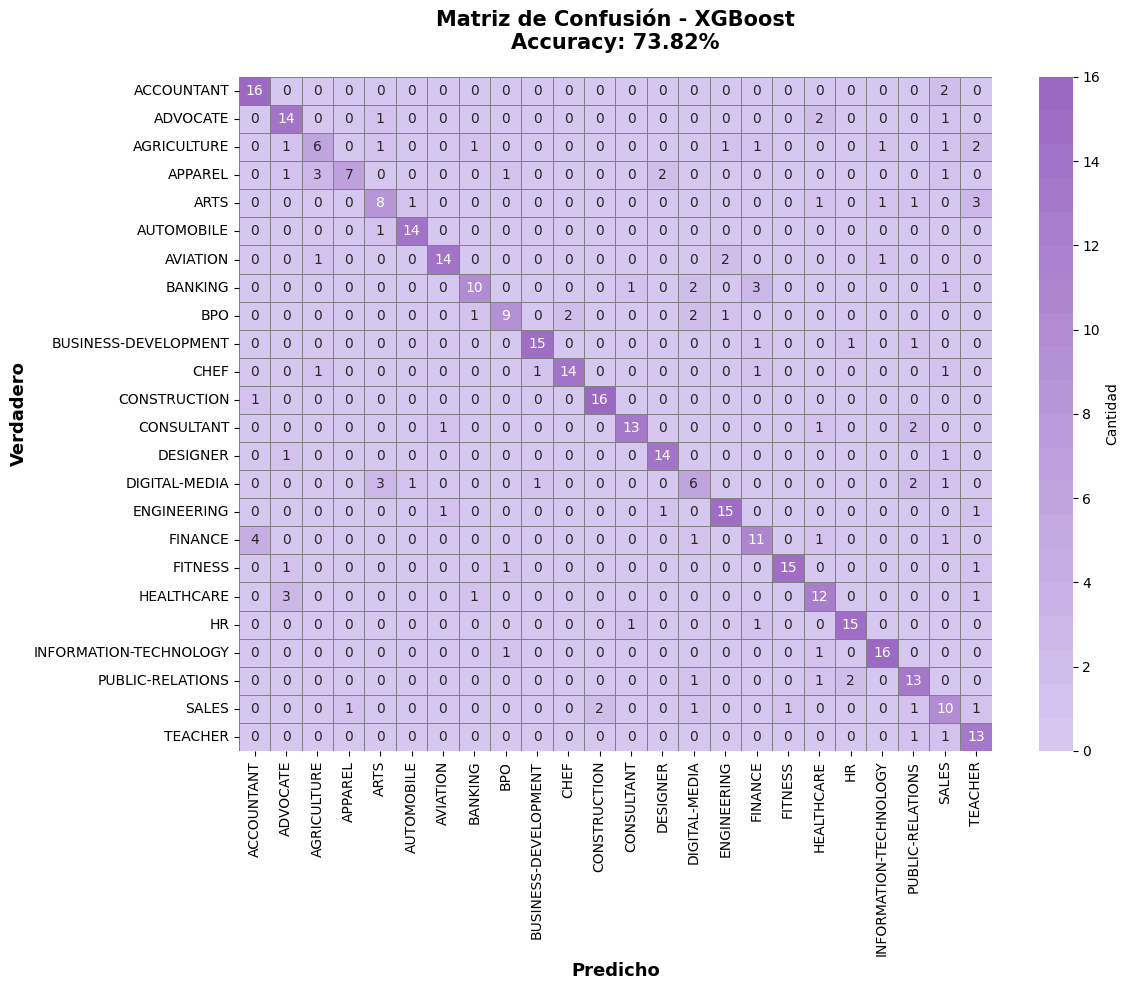

In [30]:
labels = Y_test
preds = preds_test

mostrar_matriz_confusion(
    y_true=labels,
    y_pred=preds,
    category_map=category_map,
    titulo=f"Matriz de Confusión - XGBoost\nAccuracy: {metrics_test['accuracy']*100:.2f}%"
)

La **Matriz de Confusión** del modelo **TF-IDF + XGBoost**, con una precisión general del **73.82%**, ofrece una visión detallada del rendimiento por clase. El modelo clasifica correctamente la mayoría de los puestos de trabajo, mostrando gran efectividad en dominios claramente diferenciados. Las confusiones más frecuentes ocurren entre clases con vocabularios semánticamente cercanos, indicando que el modelo tiene dificultades para separar matices entre categorías altamente relacionadas.

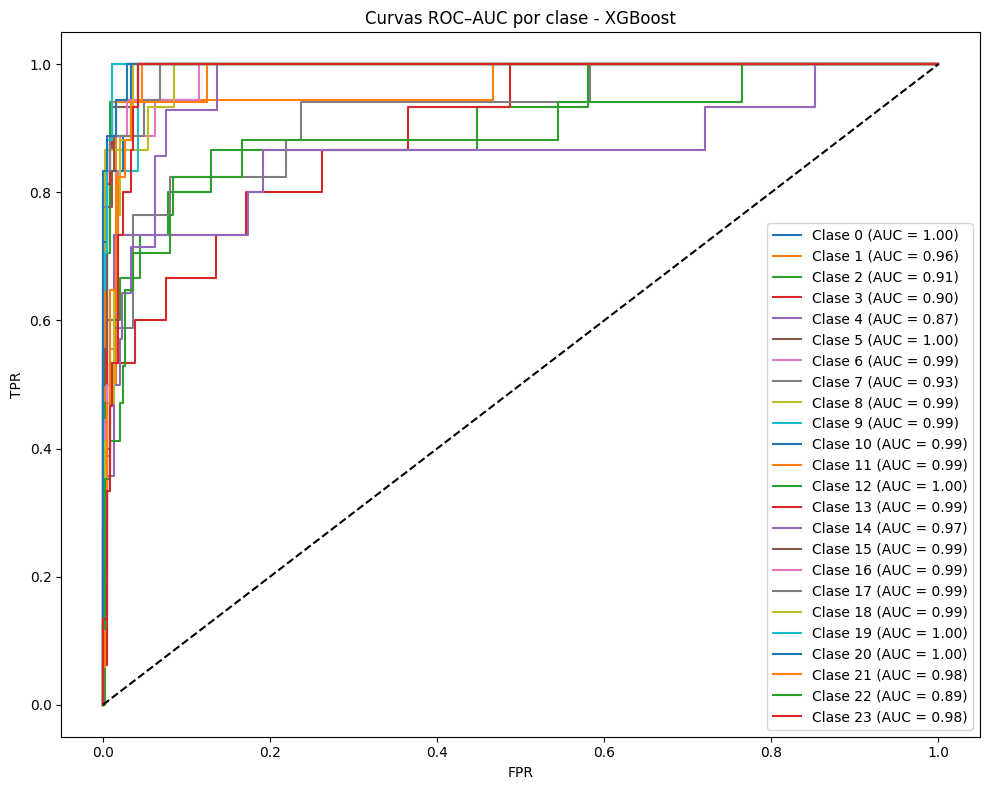

In [44]:
mostrar_curvas_roc(
    y_true=Y_test,
    y_prob=probs_test,
    num_classes=NUM_CLASSES,
    titulo="Curvas ROC–AUC por clase - XGBoost"
)

Las **curvas ROC-AUC por clase** del modelo **XGBoost** confirman una **capacidad discriminativa alta y consistente** en clasificación multiclase. Con valores de AUC entre **0.87 y 1.00**, el modelo logra separar correctamente las clases en términos probabilísticos, incluso en aquellas con menor precisión en la matriz de confusión. Esto indica que el modelo asigna **probabilidades bien calibradas**, permitiendo distinguir entre clases con alta **sensibilidad** y **especificidad**.


### Análisis de errores

In [46]:
analizar_errores(
    y_true=Y_test,
    y_pred=preds_test,
    category_map={i: f"Clase {i}" for i in range(NUM_CLASSES)},
    nombre_modelo="XGBoost"
)

 RESUMEN DE ERRORES - XGBoost
 Predicciones correctas: 296
 Predicciones incorrectas: 105
 Total de ejemplos: 401
 Accuracy: 73.82%
 Tasa de error: 26.18%

 ERRORES POR CLASE:
------------------------------------------------------------
Clase 0                  : 2/18 errores (88.89% accuracy)
Clase 1                  : 4/18 errores (77.78% accuracy)
Clase 2                  : 9/15 errores (40.00% accuracy)
Clase 3                  : 8/15 errores (46.67% accuracy)
Clase 4                  : 7/15 errores (53.33% accuracy)
Clase 5                  : 1/15 errores (93.33% accuracy)
Clase 6                  : 4/18 errores (77.78% accuracy)
Clase 7                  : 7/17 errores (58.82% accuracy)
Clase 8                  : 6/15 errores (60.00% accuracy)
Clase 9                  : 3/18 errores (83.33% accuracy)
Clase 10                 : 4/18 errores (77.78% accuracy)
Clase 11                 : 1/17 errores (94.12% accuracy)
Clase 12                 : 4/17 errores (76.47% accuracy)
Clase 13 

A pesar de la sólida **Accuracy global del 73.82%**, el análisis detallado revela una heterogeneidad significativa en el rendimiento por clase. Las clases **2 (40.00%)**, **14 (42.86%)**, **3 (46.67%)** y **4 (53.33%)** se identifican como los puntos débiles del modelo, concentrando la mayor proporción de errores, en contraste con la clasificación casi perfecta de otras clases, como la **Clase 11 (94.12%)**.

Los patrones de confusión más frecuentes destacan la fuerte tendencia del modelo a confundir la **Clase 16 con la Clase 0** (el error más común, 3.8% del total), así como confusiones recurrentes entre otras clases problemáticas (**Clase 3 → Clase 2**, **Clase 14 → Clase 4**). Estos ejemplos sugieren que el vocabulario TF-IDF no es suficientemente distintivo o que el desbalance de clases afecta el entrenamiento, requiriendo estrategias específicas para mejorar el rendimiento en estas categorías.


## Modelo 5: FastText

El sistema utiliza la librería **FastText** para la clasificación de texto, un modelo conocido por su alta eficiencia y rendimiento, combinando la velocidad de una red *feed-forward* con la riqueza semántica de los *embeddings* de subpalabras (*n-gramas* de caracteres). Esta implementación incorpora vectores de palabras **pre-entrenados (cc.en.300.vec)**.

In [48]:
import fasttext
import fasttext.util

In [49]:
# CONFIGURACIÓN  
RESULTS_DIR = 'results_fasttext'
os.makedirs(RESULTS_DIR, exist_ok=True) 

El modelo se entrena en modo supervisado utilizando **FastText** (`fasttext.train_supervised`), aprovechando **embeddings preentrenados** para acelerar la convergencia y mejorar la calidad de las representaciones semánticas. Se emplea el archivo `pretrainedVectors='modelos/cc.en.300.vec'`, inicializando los vectores de palabras con **300 dimensiones**, lo que permite que el modelo comience con un conocimiento semántico sólido mediante **Transfer Learning**.

La configuración del modelo incluye una **dimensión de embeddings de 300** (`dim=300`), **función de pérdida Softmax** (`loss='softmax'`) para clasificación multiclase, **25 épocas** de entrenamiento (`epoch=25`) y una **tasa de aprendizaje alta** (`lr=0.5`) para favorecer la convergencia rápida.  

Para la representación del texto, se utilizan **bigramas de palabras** (`wordNgrams=2`) que capturan el contexto local, mientras que los *n-gramas* de caracteres se desactivan (`minn=0`, `maxn=0`) confiando únicamente en los embeddings de palabras completas y sus n-gramas de palabras, lo cual es apropiado al usar vectores preentrenados de alta calidad.  

El entrenamiento se realiza sobre un **corpus etiquetado** en formato `.txt`, donde cada línea contiene una etiqueta y un texto. Esta configuración permite obtener un clasificador multiclase eficiente, con representaciones semánticas sólidas y capacidad de capturar relaciones contextuales locales entre palabras.


In [50]:
# 1. Entrenar clasificador con embeddings pre-entrenados
print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO")
print("="*70)

start_time = time.time()

model = fasttext.train_supervised(
    input='processed_data/fasttext_train.txt',
    
    pretrainedVectors='/home/sara/modelos/cc.en.300.vec/cc.en.300.vec',
    
    dim=300,              
    epoch=50,
    lr=0.5,
    wordNgrams=2,         
    
    loss='softmax',
    minCount=1,          
    
    bucket=2000000,
    minn=0,               
    maxn=0,               
    
    thread=8,
    verbose=2
)

training_time = time.time() - start_time
print(f"\n Entrenamiento completado en {training_time:.2f} segundos!")

model.save_model(os.path.join(RESULTS_DIR, 'fasttext_model_pretrained.bin'))
print(f" Modelo guardado: {RESULTS_DIR}/fasttext_model_pretrained.bin")


ENTRENAMIENTO DEL MODELO


Read 1M words
Number of words:  39142
Number of labels: 24
Progress:  99.0% words/sec/thread: 1782576 lr:  0.004948 avg.loss:  0.221382 ETA:   0h 0m 0s 38.0% words/sec/thread: 1392684 lr:  0.310102 avg.loss:  0.566606 ETA:   0h 0m 8s words/sec/thread: 1447277 lr:  0.284387 avg.loss:  0.497748 ETA:   0h 0m 7s


 Entrenamiento completado en 111.26 segundos!
 Modelo guardado: results_fasttext/fasttext_model_pretrained.bin


Progress: 100.0% words/sec/thread: 1784194 lr:  0.000000 avg.loss:  0.219314 ETA:   0h 0m 0s


Se evalúa el modelo sobre el conjunto de validación utilizando el método test() de FastText, que calcula precisión y recall directamente.

In [52]:
# 2. Evaluación en Validación

print("\n" + "="*70)
print(" EVALUACIÓN EN VALIDACIÓN")
print("="*70)

n_val, precision_val, recall_val = model.test('processed_data/fasttext_val.txt')
f1_val = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

print(f"Samples: {n_val}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")


 EVALUACIÓN EN VALIDACIÓN
Samples: 401
Precision: 0.7057
Recall: 0.7057
F1-Score: 0.7057


El análisis de las métricas de evaluación en el conjunto de validación del modelo indica un rendimiento **sólido y equilibrado** con un **F1-Score de 0.7057**. La coincidencia de los valores de Precisión, *Recall* y F1-Score sugiere una distribución uniforme de errores bajo el umbral de clasificación estándar de la librería. Este resultado inicial, si bien es robusto y producto de la transferencia de conocimiento semántico aportado por los *embeddings* preentrenados de 300 dimensiones, se sitúa ligeramente **por debajo** del F1-Score máximo alcanzado por la arquitectura **Bi-LSTM**, lo que requiere una evaluación exhaustiva en el conjunto de prueba para determinar la capacidad de generalización comparativa de ambos modelos.

Para obtener una evaluación más completa, se realiza una predicción manual y robusta sobre el conjunto de *Test*.

* **Manejo de Datos:** El archivo de *Test* se carga de forma manual para separar el texto y las etiquetas *string* originales (`__label__X`). Las etiquetas se mapean a índices numéricos para la compatibilidad con las librerías de métricas de Python (ej., `scikit-learn`).
* **Predicción Robusta:** Se realiza un bucle de predicción por muestra (`model.predict(text, k=num_classes, threshold=0.0)`):
    * Se solicita a FastText que devuelva las probabilidades para **todas las clases** (`k=num_classes`, $\text{threshold}=0.0$).
    * Esto es esencial para construir el vector de probabilidades (`probs_test_all`), necesario para el cálculo preciso de métricas avanzadas como el **ROC-AUC (macro)**.
    * Se implementa un manejo de errores (try/except) y un *fallback* para asegurar que el proceso no se interrumpa ante datos inválidos y que la salida tenga el formato correcto para las métricas.

In [53]:
# 3. Cargar datos de test
print("\n Cargando datos de test...")

def load_fasttext_file(filepath):
    """Carga archivo FastText manteniendo etiquetas como strings"""
    texts = []
    labels = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                label = parts[0].replace('__label__', '')  
                text = parts[1]
                texts.append(text)
                labels.append(label)
    return texts, np.array(labels)

test_texts, Y_test_str = load_fasttext_file('processed_data/fasttext_test.txt')

# Obtener todas las etiquetas únicas
unique_labels = sorted(np.unique(Y_test_str))
num_classes = len(unique_labels)

# Crear mapeo de etiquetas
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Convertir etiquetas a índices numéricos para métricas
Y_test = np.array([label_to_idx[label] for label in Y_test_str])



 Cargando datos de test...


In [ ]:
# 4. Predicciones en Test (VERSIÓN ROBUSTA)
preds_test_str = []
preds_test = []
probs_test_all = []

print(f"\n Prediciendo en {len(test_texts)} muestras de test...")

for i, text in enumerate(test_texts):
    if (i + 1) % 5000 == 0:
        print(f"   Procesados {i+1}/{len(test_texts)} ({(i+1)/len(test_texts)*100:.1f}%)...")
    
    try:
        # Método seguro: usar threshold para obtener todas las clases
        result = model.predict(text, k=num_classes, threshold=0.0)
        
        # Extraer labels y probs
        if len(result) == 2:
            labels_pred, probs_pred = result
        else:
            labels_pred = result[0]
            probs_pred = result[1] if len(result) > 1 else []
        
        # Asegurar que son listas
        if not isinstance(labels_pred, (list, tuple)):
            labels_pred = [labels_pred]
        if not isinstance(probs_pred, (list, tuple, np.ndarray)):
            probs_pred = [probs_pred]
        
        # Convertir probs a lista si es necesario
        probs_list = list(probs_pred) if hasattr(probs_pred, '__iter__') else [probs_pred]
        
        # Tomar top prediction
        if len(labels_pred) > 0:
            top_label_str = labels_pred[0].replace('__label__', '')
            preds_test_str.append(top_label_str)
            top_label_idx = label_to_idx.get(top_label_str, 0)
            preds_test.append(top_label_idx)
        else:
            # Fallback si no hay predicciones
            preds_test_str.append(unique_labels[0])
            preds_test.append(0)
        
        # Crear vector de probabilidades
        prob_vector = np.zeros(num_classes)
        for label, prob in zip(labels_pred, probs_list):
            label_str = label.replace('__label__', '')
            if label_str in label_to_idx:
                class_idx = label_to_idx[label_str]
                prob_vector[class_idx] = float(prob)
        
        probs_test_all.append(prob_vector)
        
    except Exception as e:
        print(f"   Error en muestra {i}: {e}")
        # Añadir predicción por defecto
        preds_test_str.append(unique_labels[0])
        preds_test.append(0)
        probs_test_all.append(np.zeros(num_classes))

preds_test = np.array(preds_test)
probs_test_all = np.array(probs_test_all)
print("    Predicciones completadas")


📊 Prediciendo en 401 muestras de test...
   ✅ Predicciones completadas


### Métricas en el conjunto de prueba

Se utiliza el vector de etiquetas reales (`Y_test`) y las predicciones (`preds_test`, `probs_test_all`) para calcular el rendimiento final.

In [55]:
print("\n" + "="*70)
print(" MÉTRICAS DE PERFORMANCE EN TEST")
print("="*70)

metrics = {
    'Accuracy': accuracy_score(Y_test, preds_test),
    'Precision (weighted)': precision_score(Y_test, preds_test, average='weighted', zero_division=0),
    'Precision (macro)': precision_score(Y_test, preds_test, average='macro', zero_division=0),
    'Recall (weighted)': recall_score(Y_test, preds_test, average='weighted', zero_division=0),
    'Recall (macro)': recall_score(Y_test, preds_test, average='macro', zero_division=0),
    'F1-Score (weighted)': f1_score(Y_test, preds_test, average='weighted', zero_division=0),
    'F1-Score (macro)': f1_score(Y_test, preds_test, average='macro', zero_division=0),
}

try:
    Y_test_bin = label_binarize(Y_test, classes=np.arange(num_classes))
    if num_classes == 2:
        roc_auc = roc_auc_score(Y_test, probs_test_all[:, 1])
    else:
        roc_auc = roc_auc_score(Y_test_bin, probs_test_all, multi_class='ovr', average='macro')
    metrics['ROC-AUC (macro)'] = roc_auc
except Exception as e:
    print(f"No se pudo calcular ROC-AUC: {e}")
    metrics['ROC-AUC (macro)'] = np.nan

print("\n Métricas:")
for name, value in metrics.items():
    print(f"{name:30s}: {value:.4f}")



 MÉTRICAS DE PERFORMANCE EN TEST

 Métricas:
Accuracy                      : 0.6833
Precision (weighted)          : 0.6947
Precision (macro)             : 0.6948
Recall (weighted)             : 0.6833
Recall (macro)                : 0.6837
F1-Score (weighted)           : 0.6823
F1-Score (macro)              : 0.6827
ROC-AUC (macro)               : 0.9572


El modelo **FastText** exhibió un rendimiento de generalización **inferior** en comparación con el modelo **Bi-LSTM** y es, a la postre, el **peor clasificador** entre los cinco modelos evaluados en el proyecto. Específicamente, el **F1-Score ponderado de 0.6823** y la **Accuracy de 0.6833** son modestos, confirmando la brecha de rendimiento frente a arquitecturas más complejas. No obstante, FastText demostró una fortaleza inherente al lograr un rendimiento **equilibrado** entre clases, evidenciado por la mínima diferencia entre las métricas *weighted* y *macro*. Su alta capacidad de discriminación, reflejada en un **ROC-AUC (macro) de 0.9572**, confirma que el problema no radica en distinguir probabilidades, sino en optimizar la predicción final de categorías, lo cual lo consolida como un clasificador eficiente pero de **baja efectividad** para este problema en particular.

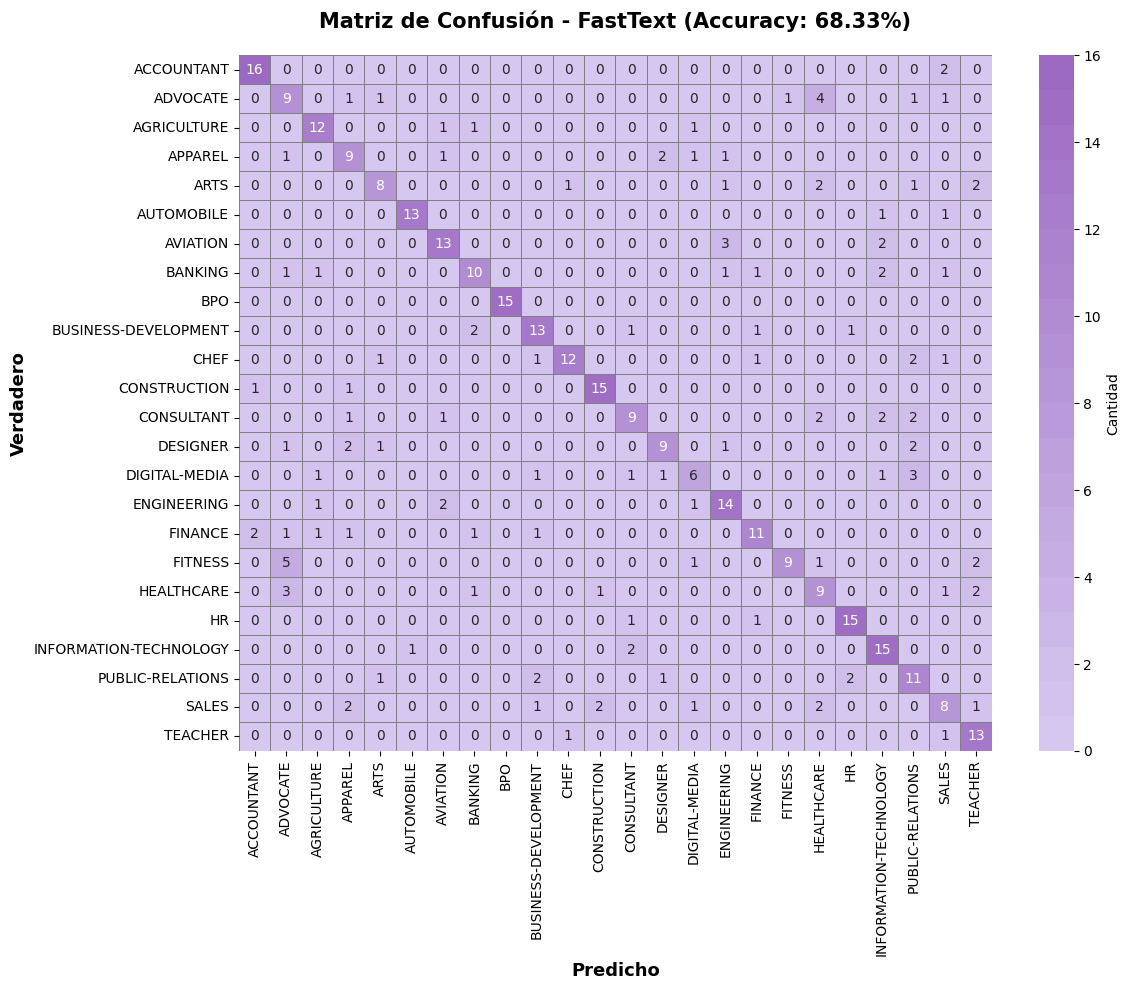

In [57]:
accuracy = accuracy_score(Y_test, preds_test)

mostrar_matriz_confusion(
    y_true=Y_test,
    y_pred=preds_test,
    category_map=idx_to_label,
    titulo=f'Matriz de Confusión - FastText (Accuracy: {metrics['Accuracy']*100:.2f}%)'
)

El modelo FastText alcanzó una **precisión (Accuracy) del 68.33%**, lo que sugiere que es un clasificador funcional, aunque con un margen considerable de mejora. La **matriz de confusión** ilustra que el modelo logra una clasificación correcta en la mayoría de las instancias, lo cual está representado por los valores altos a lo largo de la **diagonal principal**. Sin embargo, la presencia de números significativos **fuera de esta diagonal** indica que el modelo frecuentemente confunde distintas categorías, lo que resulta en una tasa de error moderada. 

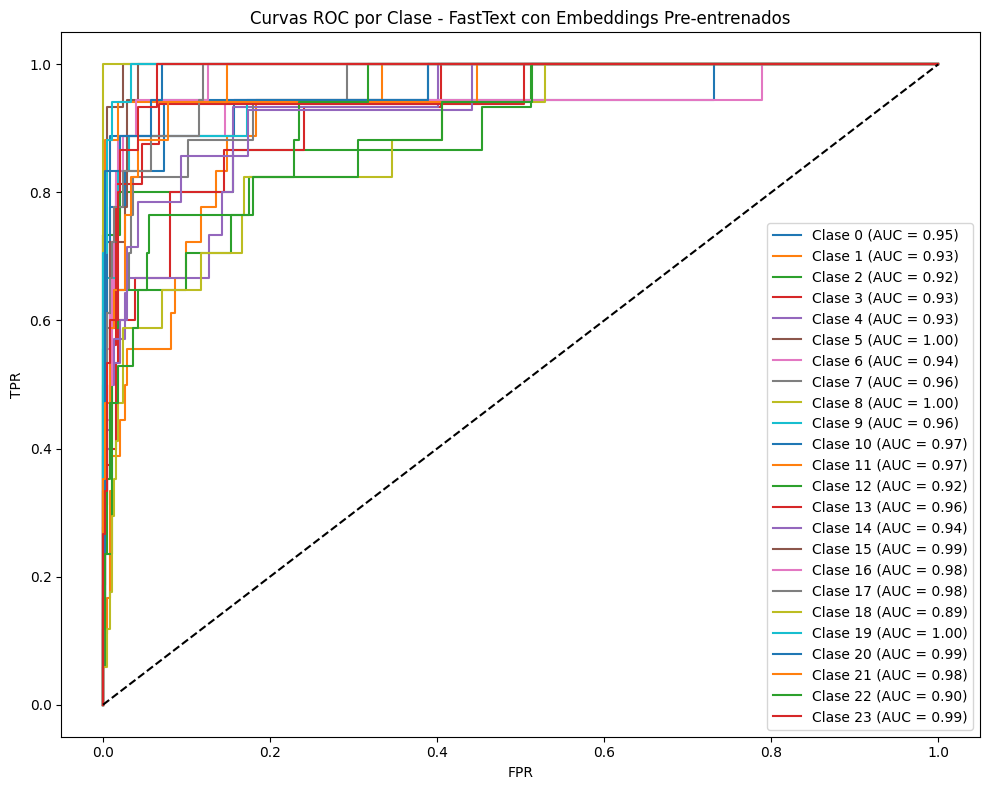

In [58]:
mostrar_curvas_roc(
    y_true=Y_test,
    y_prob=probs_test_all,
    num_classes=num_classes,
    titulo='Curvas ROC por Clase - FastText con Embeddings Pre-entrenados'
)

El modelo FastText mostró una **Precisión global del 68.33%**, limitada por la confusión entre categorías temáticamente similares, como se observa en la matriz. A pesar de esto, las **Curvas ROC** revelaron un **rendimiento individual por clase** notablemente superior: la gran mayoría de las clases alcanzaron un **AUC superior a 0.95**, indicando una fuerte capacidad de discriminación positiva. Este contraste sugiere que el modelo es robusto para la mayoría de las categorías, y su precisión general se ve afectada principalmente fallos específicos en las fronteras de ciertas clases problemáticas.

### Análisis de errores

In [20]:
analizar_errores(
    y_true=Y_test,
    y_pred=preds_test,
    category_map=idx_to_label,
    nombre_modelo='FastText con Embeddings Pre-entrenados'
)

 RESUMEN DE ERRORES - FastText con Embeddings Pre-entrenados
 Predicciones correctas: 270
 Predicciones incorrectas: 131
 Total de ejemplos: 401
 Accuracy: 67.33%
 Tasa de error: 32.67%

 ERRORES POR CLASE:
------------------------------------------------------------
ACCOUNTANT               : 2/18 errores (88.89% accuracy)
ADVOCATE                 : 9/18 errores (50.00% accuracy)
AGRICULTURE              : 3/15 errores (80.00% accuracy)
APPAREL                  : 6/15 errores (60.00% accuracy)
ARTS                     : 7/15 errores (53.33% accuracy)
AUTOMOBILE               : 1/15 errores (93.33% accuracy)
AVIATION                 : 7/18 errores (61.11% accuracy)
BANKING                  : 7/17 errores (58.82% accuracy)
BPO                      : 0/15 errores (100.00% accuracy)
BUSINESS-DEVELOPMENT     : 6/18 errores (66.67% accuracy)
CHEF                     : 6/18 errores (66.67% accuracy)
CONSTRUCTION             : 2/17 errores (88.24% accuracy)
CONSULTANT               : 8/17 err

El resumen de errores confirma la **precisión general del 67.33%** del modelo FastText, la cual está marcada por una variabilidad extrema en el rendimiento entre categorías. El modelo es **altamente fiable** en clases como **BPO (100% de precisión)** y **AUTOMOBILE (93.33%)**, pero presenta un desempeño críticamente bajo en **DIGITAL-MEDIA (42.86%)** y **SALES (47.06%)**, junto con otros roles como **ADVOCATE** y **FITNESS** que apenas superan el 50%. Las **confusiones más comunes** detalladas—particularmente **FITNESS → ADVOCATE** y el intercambio entre **ADVOCATE ↔ HEALTHCARE**—validan que la principal debilidad del modelo reside en su incapacidad para discriminar consistentemente entre clases con similitud conceptual, lo que explica la alta tasa de error general pese al buen rendimiento en categorías específicas.